In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from features.dependence import GetXYData
from models.dependence import HSICDependence
from visualization.dependence import plot_raw_variables, plot_sens_mod, plot_sens_angle, plot_sens_scatters
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df
from kernellib.dependence import HSIC, RHSIC

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')
import cartopy
import cartopy.crs as ccrs
from tqdm import tqdm
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figure_path = '/home/emmanuel/projects/2019_sakame/reports/figures/dependence/'

### Extract Data

In [3]:
year = '2011'

In [6]:
xr_dataset = xr.merge([
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/*e.nc'),
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity/*.nc')]
)



# Extract summertime months
xr_dataset = xr_dataset.sel(time=slice(str(2008), str(2010))) #.resample(time='1MS').mean(dim='time', skipna=True)

# Extract russian, european region
xr_dataset_r = xr_dataset.sel(lat = slice(66.75, 48.25), lon = slice(28.75, 60.25))
xr_dataset = xr_dataset.sel(lat = slice(70.,30.), lon = slice(-20.,35.))


# extract dates
dates = xr_dataset.time.data


In [7]:
xr_dataset

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 160, lon: 220, time: 138)
Coordinates:
  * lon                         (lon) float32 -19.875 -19.625 ... 34.625 34.875
  * lat                         (lat) float32 69.875 69.625 ... 30.375 30.125
  * time                        (time) datetime64[ns] 2008-01-05 ... 2010-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 220, 2), chunksize=(46, 220, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 160, 2), chunksize=(46, 160, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>

In [8]:
xr_dataset_r

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 74, lon: 126, time: 138)
Coordinates:
  * lon                         (lon) float32 28.875 29.125 ... 59.875 60.125
  * lat                         (lat) float32 66.625 66.375 ... 48.625 48.375
  * time                        (time) datetime64[ns] 2008-01-05 ... 2010-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 126, 2), chunksize=(46, 126, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 74, 2), chunksize=(46, 74, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 74, 126), chunksize=(46, 74, 126)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 74, 126), chunksize=(46, 74, 126)>

### Plot Raw Variables

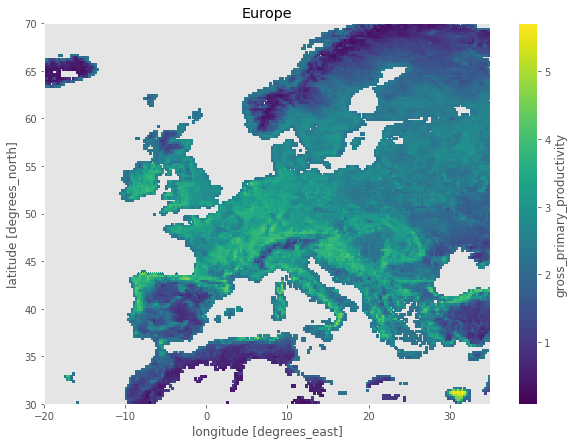

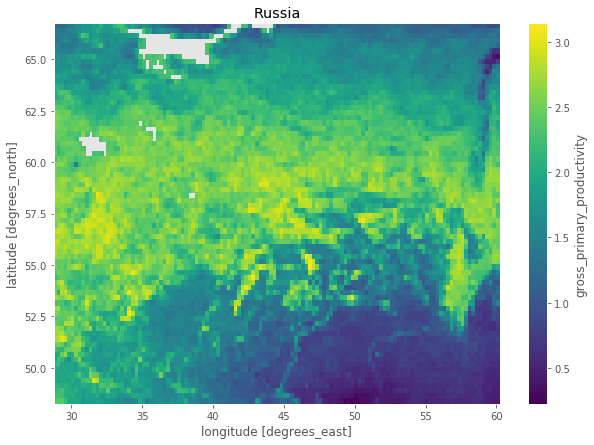

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Europe')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Russia')
plt.show()

<Figure size 432x288 with 0 Axes>

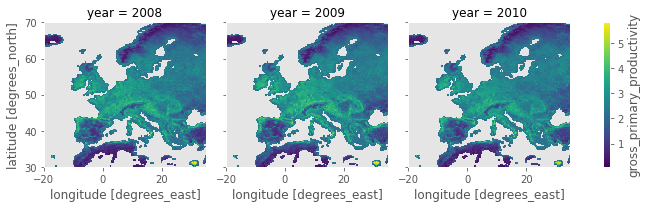

<Figure size 432x288 with 0 Axes>

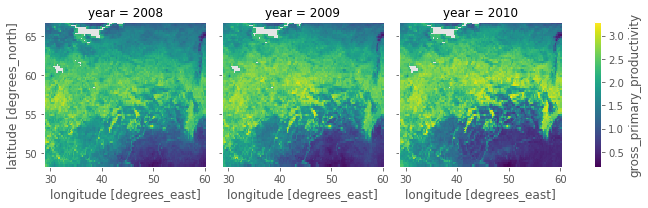

In [9]:
plt.figure()
xr_dataset['gross_primary_productivity'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()


plt.figure()
xr_dataset_r['gross_primary_productivity'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

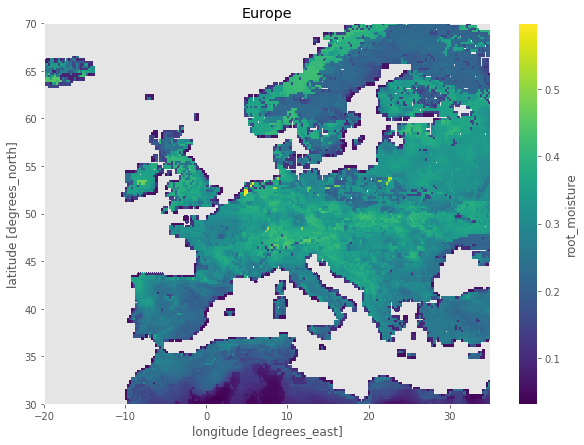

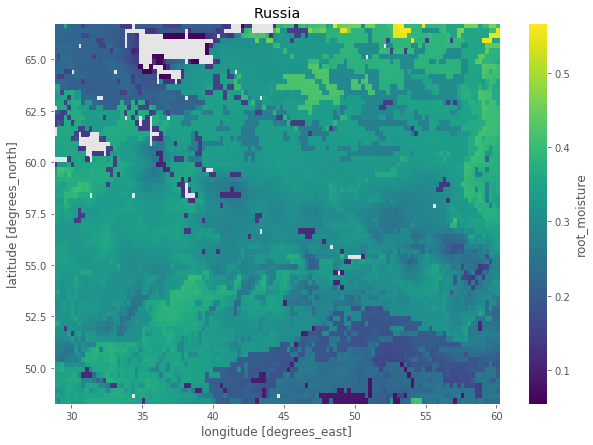

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Europe')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)
ax.set_title('Russia')
plt.show()

<Figure size 432x288 with 0 Axes>

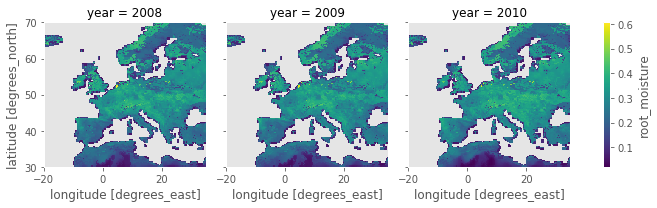

<Figure size 432x288 with 0 Axes>

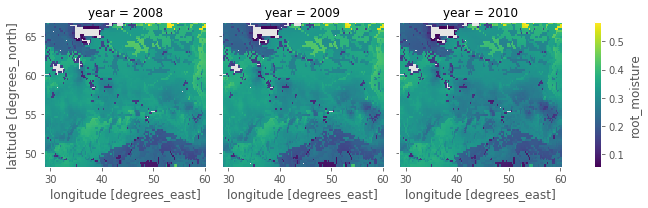

In [11]:
plt.figure()
xr_dataset['root_moisture'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

plt.figure()
xr_dataset_r['root_moisture'].groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon', y='lat', col='year', col_wrap=3)
plt.show()

### Conversion: Pandas DataFrame & Xarray Dataset

In [10]:
# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

In [11]:
# convert xarray to df
def create_df(xr_array, variable='gross_primary_productivity'):
    """Function to convert an xarray into a dataframe.
    This also preserves the lat and lon coordinates."""
    # Subset
    try:
        xr_df = xr_array.where(xr_array.mask==1).mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
        # drop mask
        xr_df = xr_df.drop('mask', 1)
    except AttributeError:
        xr_df = xr_array.mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
    except:
        pass
    
    
    # Remove duplicates
    xr_df = xr_df.reset_index().pivot_table(
        index=range(xr_df.shape[0]),
        values=[variable, 'lat', 'lon']
    ).drop_duplicates()
    
    return xr_df

# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

#### Convert XARRAY to DATAFRAME

In [9]:
variable = 'gross_primary_productivity'

gpp_df = create_df(xr_dataset, variable)

gpp_df.head()

gross_primary_productivity     lat     lon
0                    2.314191  69.875  18.125
1                    2.244336  69.875  18.375
2                    2.246074  69.875  18.625
3                    1.192227  69.875  18.875
4                    1.226036  69.875  19.125

#### Convert DATAFRAME to XARRAY

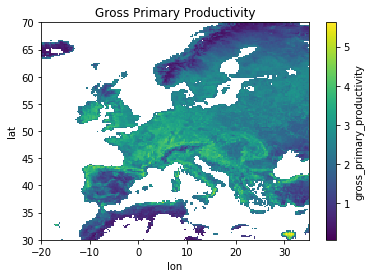

In [10]:
gpp_xr = create_xarray(gpp_df, variable)

fig, ax = plt.subplots()

gpp_xr[variable].plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

In [11]:
gpp_df = create_df(xr_dataset, variable='gross_primary_productivity')
sm_df = create_df(subset, variable='soil_moisture')

var_df = gpp_df.merge(sm_df)
var_df = var_df.dropna()



NameError: name 'subset' is not defined

In [17]:
print(X.shape)

(23770,)


## Preliminary Data Exploration

### Extract Data with time as dimension

## Experiment 0 - Pearson Correlation - Time

In [9]:
def pearson_corr_coeff(X, Y):
    
    # Get Mean
    X_mean = X.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    Y_mean = Y.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    
    # Calculate Covariance
    cov = (X - X_mean) * (Y - Y_mean)
    print(cov)
    # Get STD
    X_std = X.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    Y_std = Y.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    
    # Get Correlation Coefficient
    corr_coef = cov / (X_std * Y_std)

    # Get mean of coordinates
    corr_coef = corr_coef.mean(dim=['lat', 'lon'], skipna=True).compute()

    return corr_coef

In [10]:
%%time

phsic_times = pearson_corr_coeff(
    xr_dataset.gross_primary_productivity,
    xr_dataset.root_moisture,
)

phsic_times_r = pearson_corr_coeff(
    xr_dataset_r.gross_primary_productivity,
    xr_dataset_r.root_moisture,
)

<xarray.DataArray (time: 138, lat: 160, lon: 220)>
dask.array<shape=(138, 160, 220), dtype=float32, chunksize=(1, 160, 220)>
Coordinates:
  * lon      (lon) float32 -19.875 -19.625 -19.375 ... 34.375 34.625 34.875
  * lat      (lat) float32 69.875 69.625 69.375 69.125 ... 30.625 30.375 30.125
  * time     (time) datetime64[ns] 2008-01-05 2008-01-13 ... 2010-12-31
<xarray.DataArray (time: 138, lat: 74, lon: 126)>
dask.array<shape=(138, 74, 126), dtype=float32, chunksize=(1, 74, 126)>
Coordinates:
  * lon      (lon) float32 28.875 29.125 29.375 29.625 ... 59.625 59.875 60.125
  * lat      (lat) float32 66.625 66.375 66.125 65.875 ... 48.875 48.625 48.375
  * time     (time) datetime64[ns] 2008-01-05 2008-01-13 ... 2010-12-31
CPU times: user 10.9 s, sys: 25.6 s, total: 36.5 s
Wall time: 13.1 s


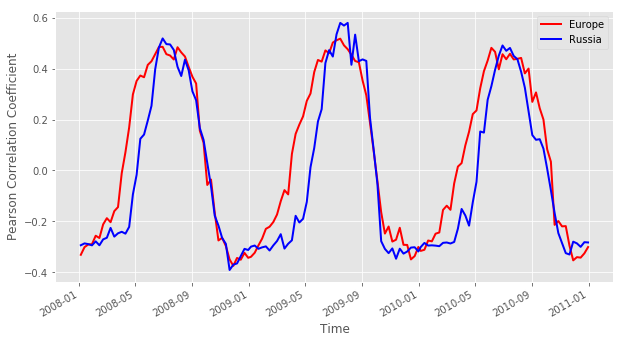

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

phsic_times.plot(ax=ax, label='Europe', color='red', linewidth=2)
phsic_times_r.plot(ax=ax, label='Russia', color='blue', linewidth=2)
ax.set_ylabel('Pearson Correlation Coefficient')
ax.set_xlabel('Time')
ax.legend()
fig.savefig(figure_path + '0_pearson_46.png')
plt.show()

## Experiment I - Linear HSIC - Time

### Europe

In [12]:
%%time

# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
lhsic_times = list()
lhsic_mods = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime, itime)) 
    
    
    subsample = 5000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
#     fig, ax = plt.subplots()
    
#     ax.hist(X, bins=100)
#     plt.show()
#     fig, ax = plt.subplots()
    
#     ax.hist(Y, bins=100)
#     plt.show()
    model = 'linear'
    subsample = 5000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods.append(lhsic_model.get_mod())
    lhsic_times.append(hsic_val)
#     break

100%|██████████| 138/138 [06:31<00:00,  2.79s/it]

CPU times: user 1h 34min 41s, sys: 59min 5s, total: 2h 33min 47s
Wall time: 6min 31s


In [ ]:
# Save Results
results = dict()

# Linear HSIC (Europe)
results['lhsic_mods'] = lhsic_mods
results['lhsic_times'] = lhsic_times

# Linear HSIC (Russia)
results['lhsic_mods_r'] = lhsic_mods
results['lhsic_times_r'] = lhsic_times

# Linear dHSIC
results['']

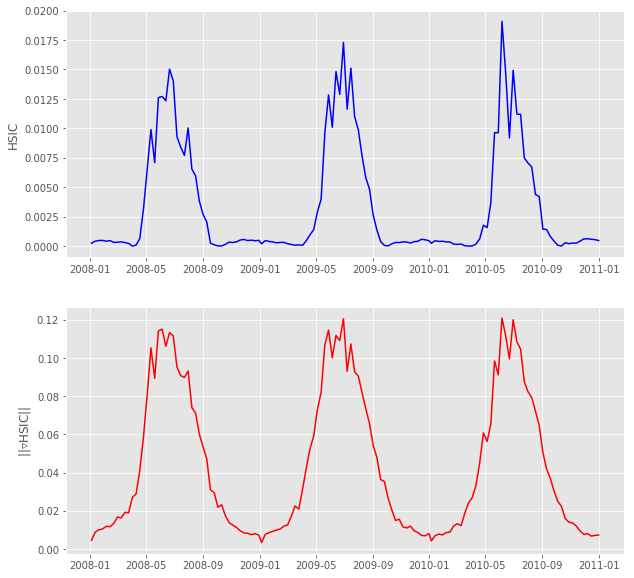

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, lhsic_times, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(lhsic_mods).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

### Russia

In [14]:
%%time

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
lhsic_times_r = list()
lhsic_mods_r = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(itime, itime)) 
    
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)

    model = 'linear'
    subsample = 4000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods_r.append(lhsic_model.get_mod())
    lhsic_times_r.append(hsic_val)

100%|██████████| 138/138 [03:48<00:00,  1.65s/it]

CPU times: user 49min 58s, sys: 48min 28s, total: 1h 38min 27s
Wall time: 3min 48s


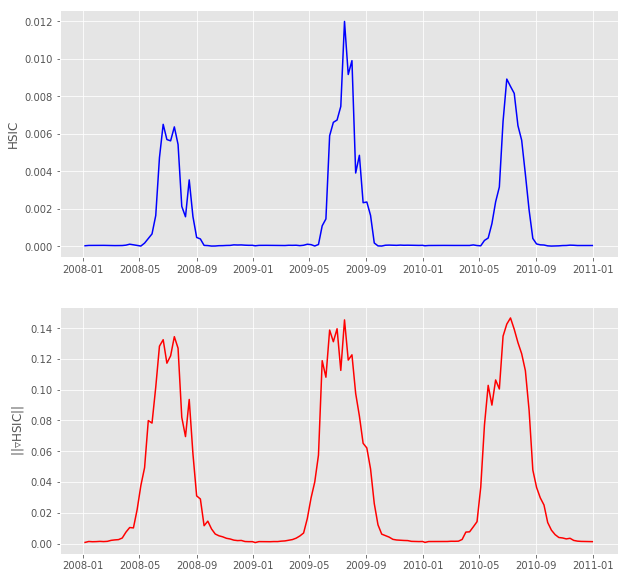

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, lhsic_times_r, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(lhsic_mods_r).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

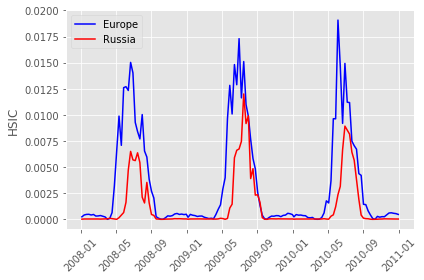

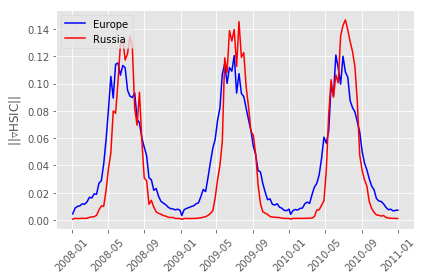

In [254]:
# HSIC
fig, ax = plt.subplots(nrows=1)
ax.plot(times, lhsic_times, label='Europe', color='blue')
ax.plot(times, lhsic_times_r, label='Russia', color='red')
# ax.plot(times, np.array(lhsic_times) - np.array(lhsic_times_r), label='EU-R', color='green')
ax.set_ylabel('HSIC')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# fig.savefig(figure_path + 'lhsic_46.png')
plt.show()

# dHSIC
fig, ax = plt.subplots()
ax.plot(times, np.hstack(lhsic_mods).mean(axis=0), label='Europe', color='blue')
ax.plot(times, np.hstack(lhsic_mods_r).mean(axis=0), label='Russia', color='red')
ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'ldhsic_46.png')
plt.show()

# # P-Value HSIC (Europe, Russia)
# fig, ax = plt.subplots()
# ax.plot(times, np.abs(np.array(lhsic_times_r) - np.array(lhsic_times)), color='green')
# ax.set_ylabel(r'$\Delta_p$')
# plt.xticks(rotation=45)
# plt.tight_layout()
# fig.savefig(figure_path + 'lphsic_46.png')
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(times, np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0)), color='green')
# ax.set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
# plt.xticks(rotation=45)
# plt.tight_layout()
# fig.savefig(figure_path + 'lpdhsic_46.png')
# plt.show()

# for iax in [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]:
#     for label in iax.get_xticklabels():
#         label.set_rotation(45) 


# fig.savefig(figure_path + 'lhsic_46.png')


# plt.show()

In [58]:
marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]

In [76]:
for x, y  in marks:

    t1 = np.concatenate([ldhsic_delta[x[0]:x[1]] , ldhsic_delta[y[0]:y[1]]])
    break

(33,)


In [84]:
marks = [((0, 18), (31, 46)), ((46, 46 + 18), (46 + 31, 46*2)), ((2*46, 2*46 + 18), (2*46 + 31, 46*3))]

areas['non_drought'] = [np.trapz(np.concatenate([ldhsic_delta[x[0]:x[1]] , 
                                             ldhsic_delta[y[0]:y[1]]])) for x, y  in marks]

In [85]:
marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
areas['before_drought'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

[0.49352386649948765, 0.5577470724210221, 0.418470402698663]

In [ ]:
marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
areas['after_drought'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

In [219]:
dareas = dict()
ldhsic_delta = np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0))


# Calculate the Integrals before the normalization
marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# dareas['year'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]
dareas['year'] = [np.sum(ldhsic_delta[x:y]) for x, y  in marks]

marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
dareas['before_drought'] = [np.sum(ldhsic_delta[x:y]) for x, y  in marks]

marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
dareas['after_drought'] = [np.sum(ldhsic_delta[x:y]) for x, y  in marks]


marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
dareas['drought'] = [np.sum(ldhsic_delta[x:y]) for x, y  in marks]



# for start, stop in marks:
    
#     ldhsic_delta[start:stop] /= np.max(ldhsic_delta[start:stop])



# marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# for start, stop in marks:
    
#     ldhsic_delta[start:stop] /= np.max(ldhsic_delta[start:stop])
    
    
    
# # Integrals after normalization
# marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# dareas['year_norm'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

# marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
# dareas['drought_norm'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

# marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
# dareas['before_drought_norm'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

# marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
# dareas['after_drought_norm'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]


# marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
# dareas['drought_norm'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]


In [246]:
ldhsic_delta = np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0))

df = get_integrals(ldhsic_delta)

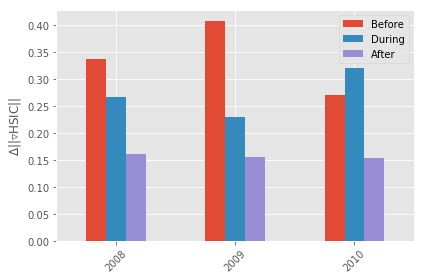

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# Plot Europe
df[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax, stacked=False)
ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
ax.legend(['Before', 'During', 'After'])
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'ldhsic_bar_46.png', transparent=False)
plt.show()

In [ ]:
df[['B','C']].div(df.A, axis=0)

In [221]:
ddf = pd.DataFrame(data=dareas, index=['2008', '2009', '2010'])

ddf2 = ddf[['before_drought', 'drought', 'after_drought']].div(ddf.year,axis=0)

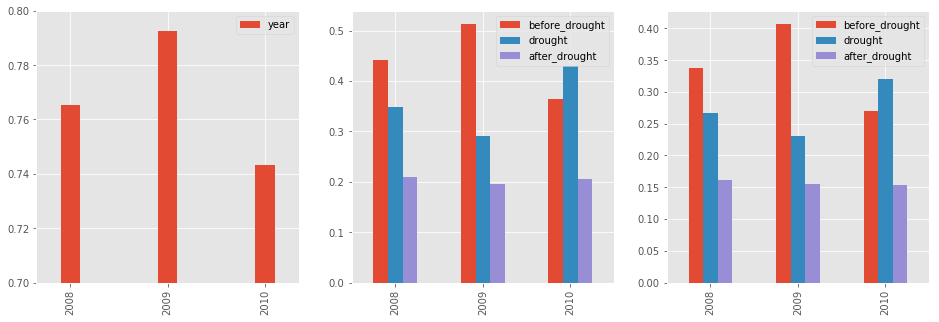

In [222]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

ddf[['year']].plot.bar(ax=ax[0], width=0.2, stacked=True)
ax[0].set_ylim([0.7, 0.8])
ddf2[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1], stacked=False)
ddf[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[2], stacked=False)

plt.show()

### LHSIC - Area

In [223]:
def get_integrals(data):
    
    areas = dict()
    
    # Before Drought
    marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
    areas['year'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # During Droughty
    marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
    areas['before_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
    areas['after_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
    areas['drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    return pd.DataFrame(data=areas, index=['2008', '2009', '2010'])

In [226]:
df_europe = get_integrals(lhsic_times)
df_russia = get_integrals(lhsic_times_r)
df_europe

year  before_drought  after_drought   drought
2008  0.159181        0.031481       0.006578  0.121122
2009  0.164571        0.022226       0.005926  0.136419
2010  0.148252        0.020191       0.006960  0.121101

In [227]:
df_europe[['before_drought', 'drought', 'after_drought']].div(df_europe.year, axis=0)

before_drought   drought  after_drought
2008        0.197771  0.760907       0.041322
2009        0.135053  0.828938       0.036009
2010        0.136193  0.816860       0.046947

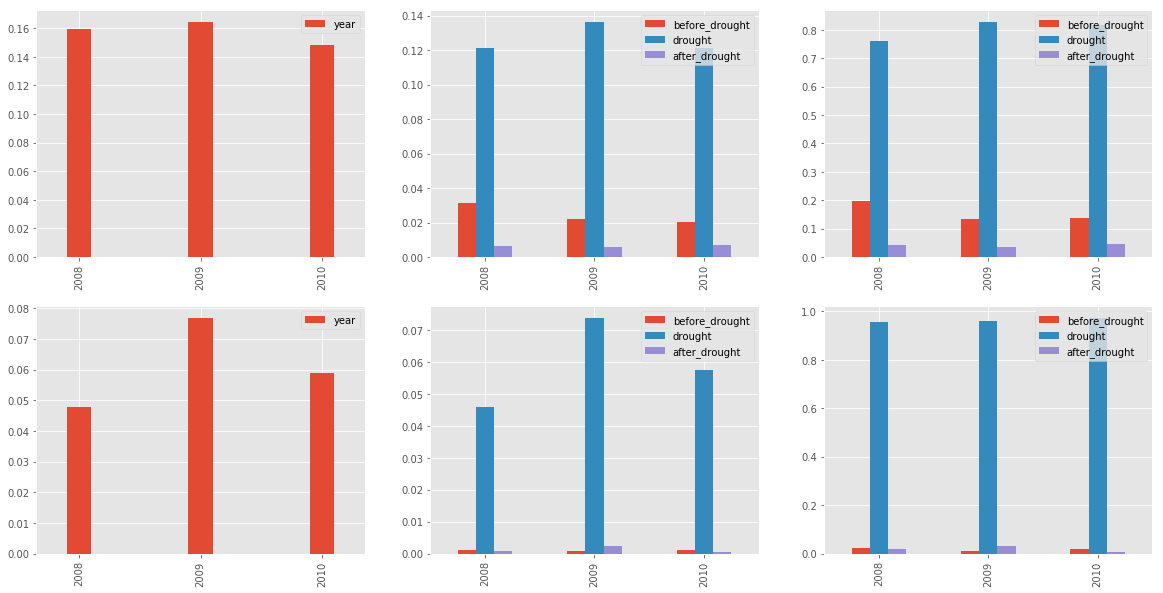

In [234]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Plot Europe
df_europe[['year']].plot.bar(ax=ax[0,0], width=0.2, stacked=True)
df_europe[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[0, 1], stacked=False)
df_europe[['before_drought', 'drought', 'after_drought']].div(df_europe.year, axis=0).plot.bar(ax=ax[0,2])

# Plot Russia
df_russia[['year']].plot.bar(ax=ax[1,0], width=0.2, stacked=True)
df_russia[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1, 1], stacked=False)
df_russia[['before_drought', 'drought', 'after_drought']].div(df_russia.year, axis=0).plot.bar(ax=ax[1,2])

plt.show()

In [235]:
ddf_europe = get_integrals(np.hstack(lhsic_mods).mean(axis=0))
ddf_russia = get_integrals(np.hstack(lhsic_mods_r).mean(axis=0))

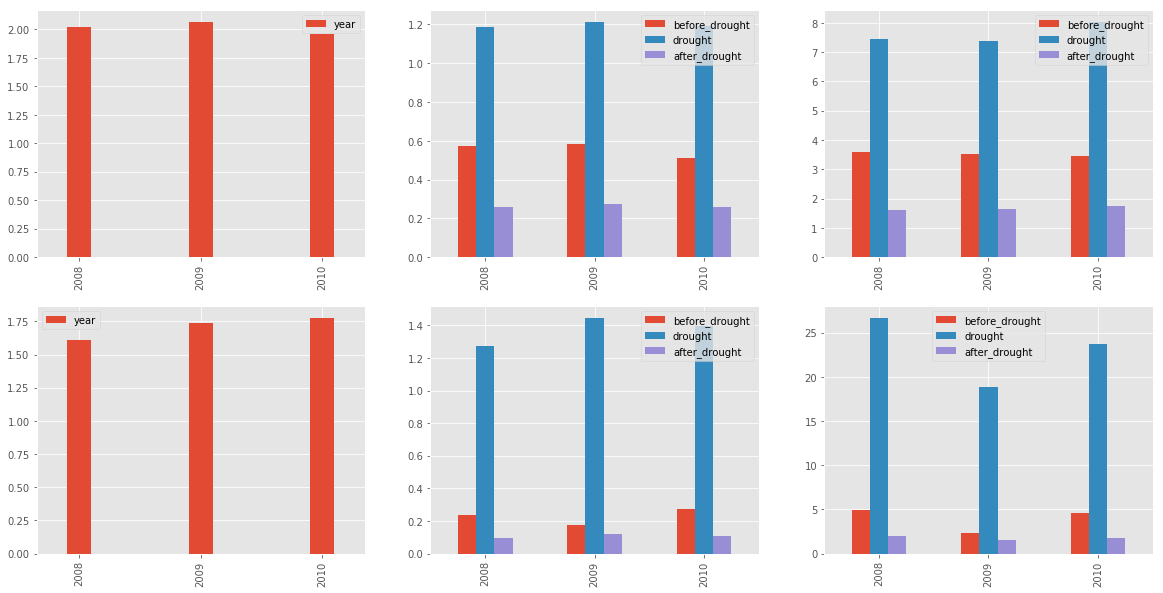

In [236]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Plot Europe
ddf_europe[['year']].plot.bar(ax=ax[0,0], width=0.2, stacked=True)
ddf_europe[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[0, 1], stacked=False)
ddf_europe[['before_drought', 'drought', 'after_drought']].div(df_europe.year, axis=0).plot.bar(ax=ax[0,2])

# Plot Russia
ddf_russia[['year']].plot.bar(ax=ax[1,0], width=0.2, stacked=True)
ddf_russia[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1, 1], stacked=False)
ddf_russia[['before_drought', 'drought', 'after_drought']].div(df_russia.year, axis=0).plot.bar(ax=ax[1,2])

plt.show()

In [189]:
areas = dict()
lhsic = dict()
df = dict()
lhsic['times_mean'] = lhsic_times #np.hstack(lhsic_mods).mean(axis=0)
lhsic['mods_mean_r'] = np.hstack(lhsic_mods_r).mean(axis=0)

# Calculate the Integrals before the normalization
marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# dareas['year'] = [np.trapz(ldhsic_delta[x:y]) for x, y  in marks]
areas['year'] = [np.sum(lhsic['times_mean'][x:y]) for x, y  in marks]

marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
areas['before_drought'] = [np.sum(lhsic['times_mean'][x:y]) for x, y  in marks]

marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
areas['after_drought'] = [np.sum(lhsic['times_mean'][x:y]) for x, y  in marks]


marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
areas['drought'] = [np.sum(lhsic['times_mean'][x:y]) for x, y  in marks]



In [190]:
areas['year']

[0.15918127386372413, 0.16457064458471116, 0.14825179279768552]

In [192]:
df['lhsic_mod'] = pd.DataFrame(data=dareas, index=['2008', '2009', '2010'])

# df['lhsic_mod'] = df['lhsic_mod'][['before_drought', 'drought', 'after_drought']].div(df['lhsic_mod'].year,axis=0)

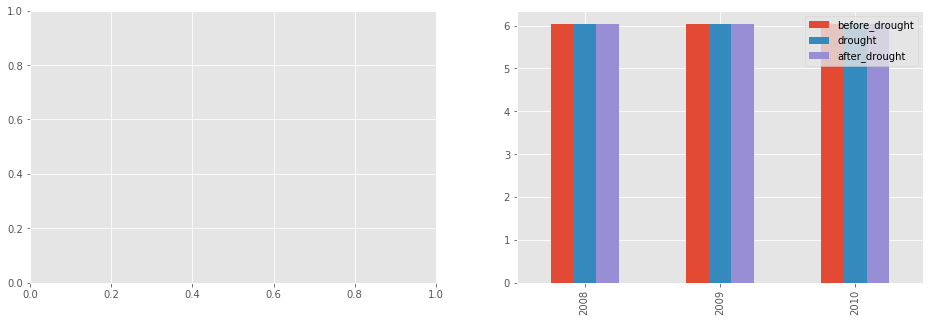

In [193]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# df['lhsic_mod'][['year']].plot.bar(ax=ax[0], width=0.2, stacked=True)
# ax[0].set_ylim([0.7, 0.8])
df['lhsic_mod'][['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1], stacked=False)

plt.show()

In [125]:
areas = dict()
lhsic_delta = np.abs(np.array(lhsic_times_r) - np.array(lhsic_times))



# Calculate the Integrals before the normalization
marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
areas['year'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
areas['before_drought'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
areas['after_drought'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]


marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
areas['drought'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]



# for start, stop in marks:
    
#     lhsic_delta[start:stop] /= np.max(lhsic_delta[start:stop])



# marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# for start, stop in marks:
    
#     lhsic_delta[start:stop] /= np.max(lhsic_delta[start:stop])
    
    
    
# # Integrals after normalization
# marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
# areas['year_norm'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

# marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
# areas['drought_norm'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

# marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
# areas['before_drought_norm'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

# marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
# areas['after_drought_norm'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]


# marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
# areas['drought_norm'] = [np.trapz(lhsic_delta[x:y]) for x, y  in marks]

In [126]:
df = pd.DataFrame(data=areas, index=['2008', '2009', '2010'])

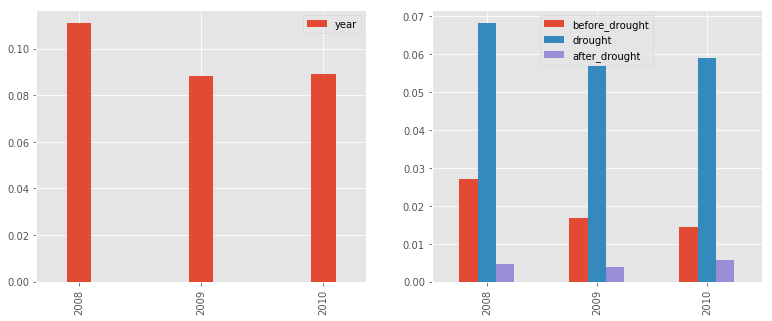

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

df[['year']].plot.bar(ax=ax[0], width=0.2)
df[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1])

plt.show()

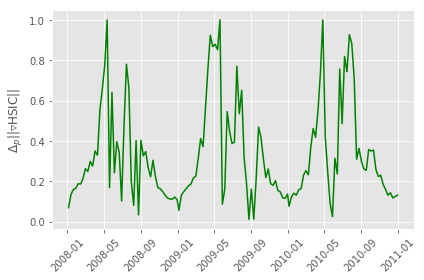

In [19]:
fig, ax = plt.subplots()

ax.plot(times, ldhsic_delta, color='green')
ax.set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'lpdhsic_46_norm.png')
plt.show()

In [20]:
marks

[(18, 31), (64, 77), (110, 123)]

In [21]:
len(ldhsic_delta)

138

In [22]:
marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
[np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

[13.588535178728224, 15.949820158210636, 15.852779934712995]

In [23]:
marks = [(18, 31), (46 + 18, 46 + 31), (46 + 18*2, 46 + 31*2)]
[np.trapz(ldhsic_delta[x:y]) for x, y  in marks]

[4.245256933857398, 4.536216131021466, 6.866624269307919]

## HSIC - RBF Kernel

### Europe

In [256]:
%%time

# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
rbfhsic_times = list()
rbfhsic_mods = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime, itime)) 
    
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)

    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    
    # Save Results
    rbfhsic_mods.append(rbfhsic_model.get_mod())
    rbfhsic_times.append(rbfhsic_model.get_hsic())

100%|██████████| 138/138 [05:59<00:00,  2.63s/it]

CPU times: user 1h 17min 53s, sys: 1h 6min 18s, total: 2h 24min 12s
Wall time: 5min 59s


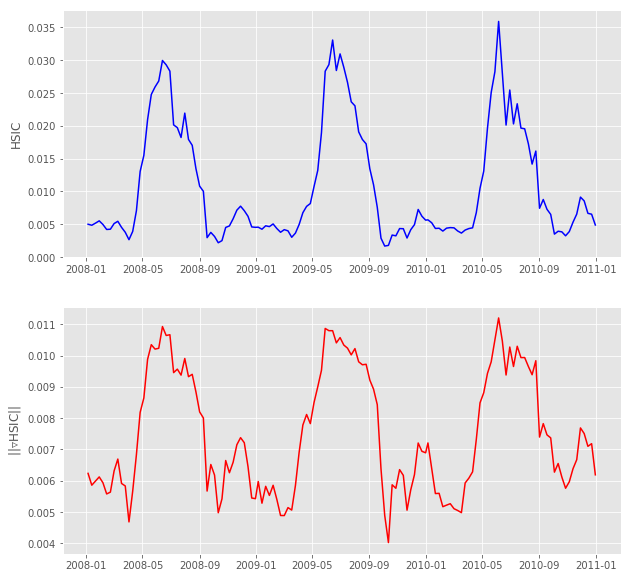

In [257]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))


ax[0].plot(times, rbfhsic_times, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(rbfhsic_mods).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

### Russia

In [258]:
%%time

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
rbfhsic_times_r = list()
rbfhsic_mods_r = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(itime, itime)) 
    
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)

    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    
    # Save Results
    rbfhsic_mods_r.append(rbfhsic_model.get_mod())
    rbfhsic_times_r.append(rbfhsic_model.get_hsic())

100%|██████████| 138/138 [05:42<00:00,  2.51s/it]

CPU times: user 1h 18min 54s, sys: 1h 5min 24s, total: 2h 24min 19s
Wall time: 5min 42s


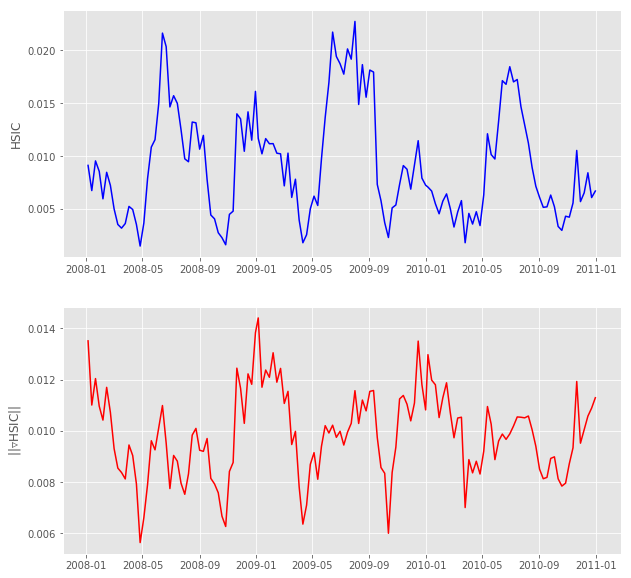

In [259]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))


ax[0].plot(times, rbfhsic_times_r, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(rbfhsic_mods_r).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

In [264]:
def get_integrals(data):
    
    areas = dict()
    
    # Before Drought
    marks = [(0, 46), (46, 46*2), (46*2, 46*3)]
    areas['year'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # During Droughty
    marks = [(0, 18), (46, 46 + 18), (2*46, 2*46 + 18)]
    areas['before_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [((31, 46)), (46 + 31, 46*2), (2*46 + 31, 46*3)]
    areas['after_drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    # After Drought
    marks = [(18, 31), (46 + 18, 46 + 31), (2*46 + 18, 2*46 + 31)]
    areas['drought'] = [np.sum(data[x:y]) for x, y  in marks]
    
    return pd.DataFrame(data=areas, index=['2008', '2009', '2010'])

In [273]:
df_europe = get_integrals(rbfhsic_times)
df_russia = get_integrals(rbfhsic_times_r)

In [276]:
df_europe

year  before_drought  after_drought   drought
2008  0.497237        0.140663       0.076905  0.279669
2009  0.508125        0.116708       0.071241  0.320177
2010  0.496869        0.132528       0.088547  0.275793

In [277]:
ddf_europe

year  before_drought  after_drought     drought
2008  1369.785006      481.480257     381.426933  506.877816
2009  1379.608616      469.558785     379.356411  530.693420
2010  1390.913240      471.073780     408.284961  511.554499

In [274]:
ddf_europe = get_integrals(rbfhsic_mods)
ddf_russia = get_integrals(rbfhsic_mods_r)

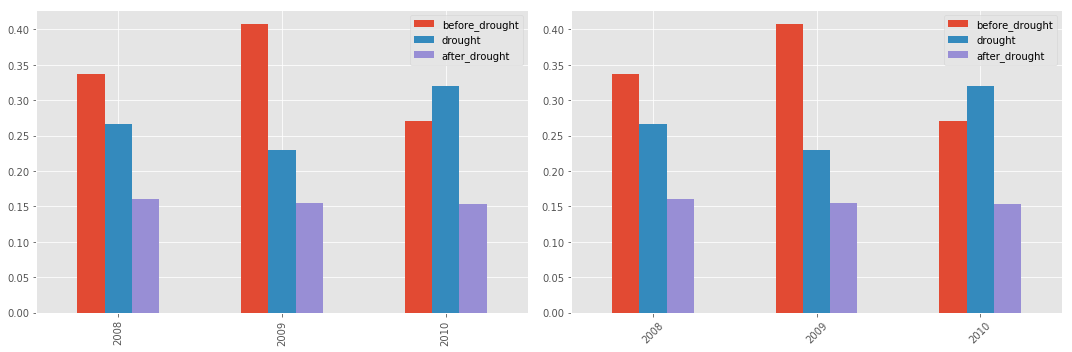

In [275]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Europe
df[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[0], stacked=False)
ddf[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax[1], stacked=False)

# ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
# ax.legend(['Before', 'During', 'After'])
plt.xticks(rotation=45)
plt.tight_layout()
# fig.savefig(figure_path + 'rbfhsic_bar_46.png', transparent=True)
plt.show()

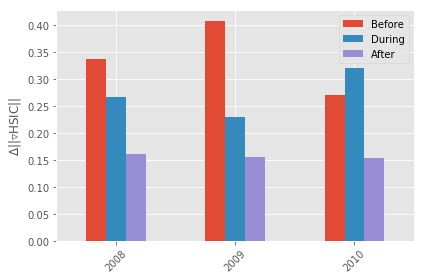

In [266]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# Plot Europe
df_europe[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax, stacked=False)
ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
ax.legend(['Before', 'During', 'After'])
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'rbfhsic_bar_46.png', transparent=True)
plt.show()

In [267]:
ddf_europe = get_integrals(rbfhsic_mods)
ddf_russia = get_integrals(rbfhsic_mods_r)

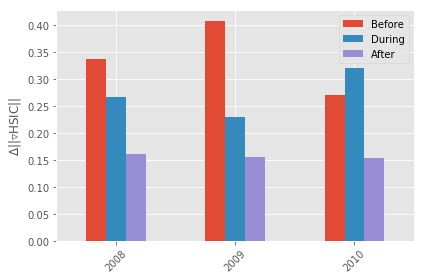

In [268]:
fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot Europe
ddf[['before_drought', 'drought', 'after_drought']].plot.bar(ax=ax, stacked=False)
ax.set_ylabel(r'$\Delta$||$\triangledown$HSIC||')
ax.legend(['Before', 'During', 'After'])
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(figure_path + 'rbdfhsic_bar_46.png', transparent=True)
plt.show()

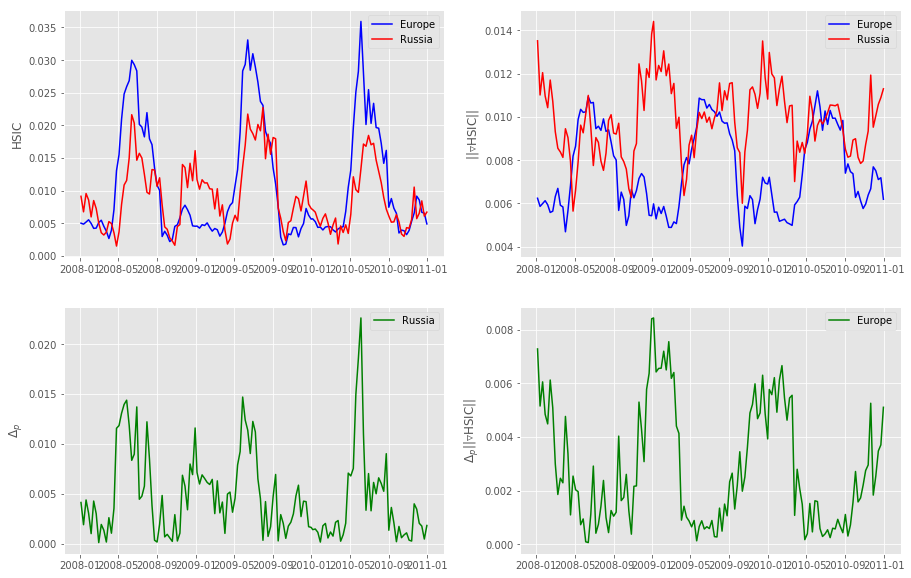

In [260]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].plot(times, rbfhsic_times, label='Europe', color='blue')
ax[0, 0].plot(times, rbfhsic_times_r, label='Russia', color='red')
ax[0, 0].set_ylabel('HSIC')
ax[0, 0].legend()


ax[0, 1].plot(times, np.hstack(rbfhsic_mods).mean(axis=0), label='Europe', color='blue')
ax[0, 1].plot(times, np.hstack(rbfhsic_mods_r).mean(axis=0), label='Russia', color='red')
ax[0, 1].set_ylabel(r'||$\triangledown$HSIC||')
ax[0, 1].legend()

ax[1, 0].plot(times, np.abs(np.array(rbfhsic_times_r) - np.array(rbfhsic_times)), label='Russia', color='green')
ax[1, 0].set_ylabel(r'$\Delta_p$')
ax[1, 0].legend()


ax[1, 1].plot(times, np.abs(np.hstack(rbfhsic_mods).mean(axis=0) - np.hstack(rbfhsic_mods_r).mean(axis=0)), label='Europe', color='green')
ax[1, 1].set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
ax[1, 1].legend()

fig.savefig(figure_path + 'rbfhsic_46.png')
plt.show()

## HSIC - RFF Kernel

### Europe

In [38]:
%%time

# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
rffhsic_times = list()
rffhsic_mods = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime, itime)) 
    
    subsample = None
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)

    model = 'rff'
    subsample = 4000
    n_features = 2000

    rffhsic_model = HSICDependence(
        model=model,
        subsample=subsample,
        n_features=n_features,
    )

    # Fit HSIC model to data
    rffhsic_model.fit_model(X , Y)
    
    # Save Results
    rffhsic_mods.append(rffhsic_model.get_mod())
    rffhsic_times.append(rffhsic_model.get_hsic())

100%|██████████| 184/184 [1:41:21<00:00, 32.27s/it]

CPU times: user 20h 51min 30s, sys: 6h 3min 20s, total: 1d 2h 54min 50s
Wall time: 1h 41min 21s


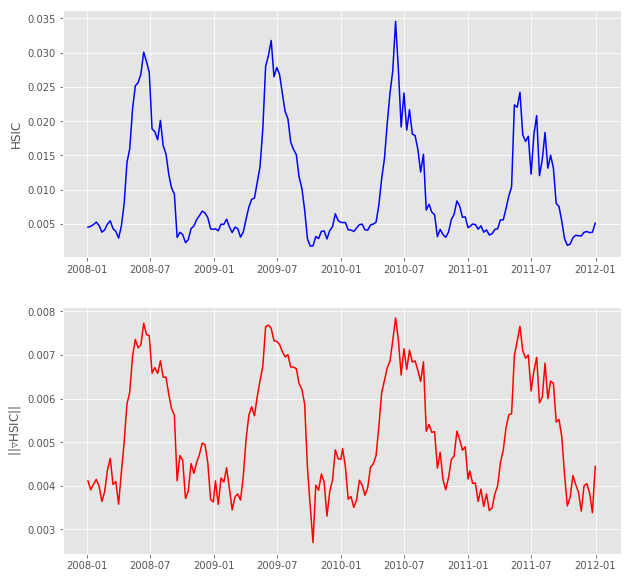

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, rffhsic_times, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(rffhsic_mods).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

### Russia

In [40]:
%%time

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
rffhsic_times_r = list()
rffhsic_mods_r = list()
pbar = tqdm(times)

for itime in pbar:
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(itime, itime)) 
    
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)

    model = 'rff'
    subsample = 4000
    n_features = 2000

    rffhsic_model = HSICDependence(
        model=model,
        subsample=subsample,
        n_features=n_features
    )

    # Fit HSIC model to data
    rffhsic_model.fit_model(X , Y)
    
    # Save Results
    rffhsic_mods_r.append(rffhsic_model.get_mod())
    rffhsic_times_r.append(rffhsic_model.get_hsic())

100%|██████████| 184/184 [16:47<00:00,  5.46s/it]

CPU times: user 2h 50min 46s, sys: 2h 19min 33s, total: 5h 10min 20s
Wall time: 16min 47s


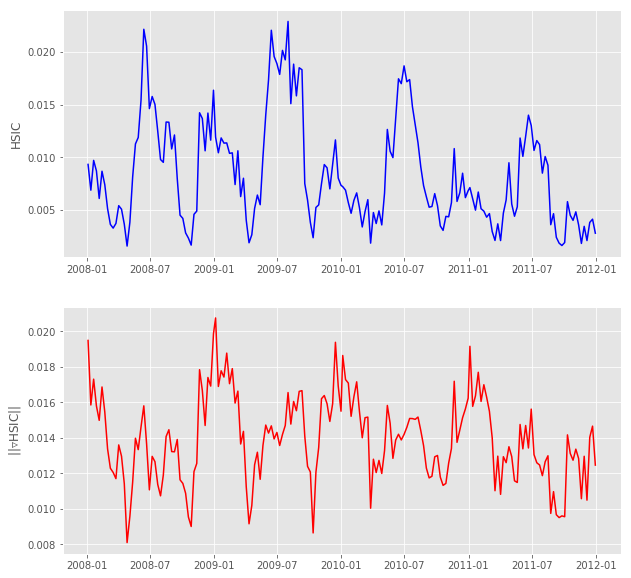

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(times, rffhsic_times_r, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(times, np.hstack(rffhsic_mods_r).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


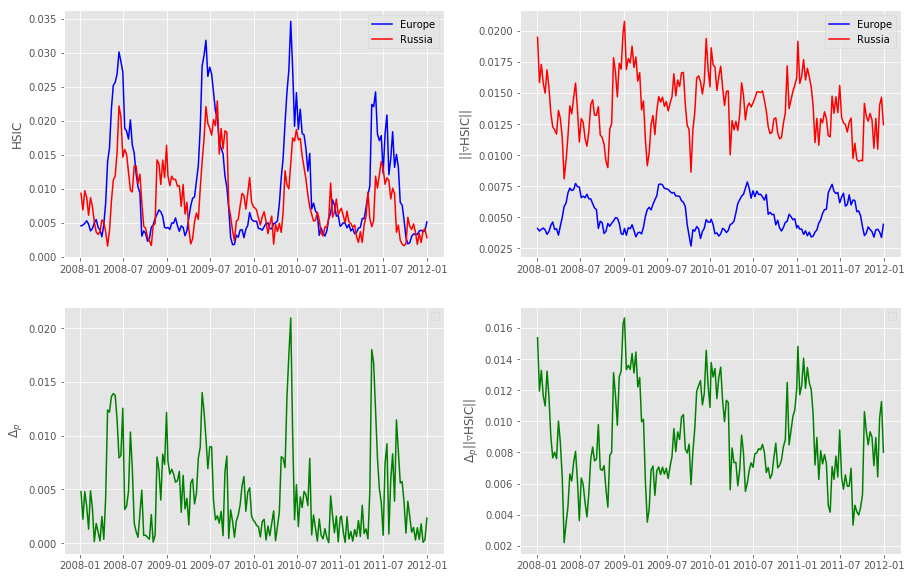

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].plot(times, rffhsic_times, label='Europe', color='blue')
ax[0, 0].plot(times, rffhsic_times_r, label='Russia', color='red')
ax[0, 0].set_ylabel('HSIC')
ax[0, 0].legend()


ax[0, 1].plot(times, np.hstack(rffhsic_mods).mean(axis=0), label='Europe', color='blue')
ax[0, 1].plot(times, np.hstack(rffhsic_mods_r).mean(axis=0), label='Russia', color='red')
ax[0, 1].set_ylabel(r'||$\triangledown$HSIC||')
ax[0, 1].legend()

ax[1, 0].plot(times, np.abs(np.array(rffhsic_times_r) - np.array(rffhsic_times)), color='green')
ax[1, 0].set_ylabel(r'$\Delta_p$')
ax[1, 0].legend()


ax[1, 1].plot(times, np.abs(np.hstack(rffhsic_mods).mean(axis=0) - np.hstack(rffhsic_mods_r).mean(axis=0)), color='green')
ax[1, 1].set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
ax[1, 1].legend()

fig.savefig(figure_path + 'rffhsic_46.png')
plt.show()

## Experiment II - GPP 2008 vs GPP 2009 vs GPP 2010

### Pearson Correlation Coefficient

In [156]:
def pearson_corr_coeff(X, Y):
    
    # Get Mean
    X_mean = X.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    Y_mean = Y.groupby('time').mean(dim=['lat', 'lon'], skipna=True)
    
    # Calculate Covariance
    cov = (X - X_mean).data * (Y - Y_mean).data
    print(cov)
    # Get STD
    X_std = X.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    Y_std = Y.groupby('time').std(dim=['lat', 'lon'], skipna=True)
    
    # Get Correlation Coefficient
    corr_coef = cov / (X_std * Y_std)

    # Get mean of coordinates
    corr_coef = corr_coef.mean(dim=['lat', 'lon'], skipna=True).compute()

    return corr_coef

In [157]:
%%time

phsic_times = pearson_corr_coeff(
    xr_dataset.sel(time=slice('2008', '2008')).gross_primary_productivity,
    xr_dataset.sel(time=slice('2009', '2009')).gross_primary_productivity,
)

phsic_times_r = pearson_corr_coeff(
    xr_dataset_r.sel(time=slice('2008', '2008')).gross_primary_productivity,
    xr_dataset_r.sel(time=slice('2009', '2009')).gross_primary_productivity,
)

dask.array<mul, shape=(12, 160, 220), dtype=float32, chunksize=(1, 160, 220)>


ValueError: operands could not be broadcast together with shapes (12, 160, 220) (0,)

In [141]:
phsic_times.data

array([], dtype=float32)

In [136]:
phsic_times.histogram(label='Europe', color='red', linewidth=2)

AttributeError: 'DataArray' object has no attribute 'histogram'

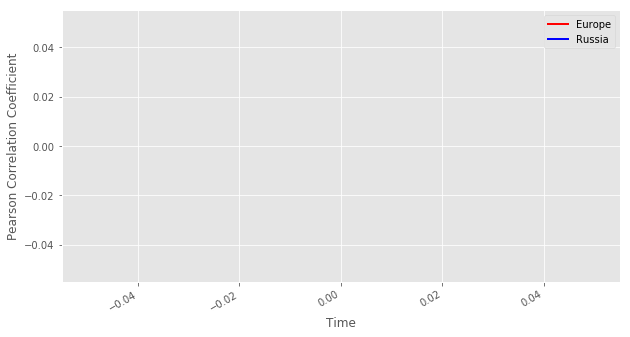

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

phsic_times.plot(ax=ax, label='Europe', color='red', linewidth=2)
phsic_times_r.plot(ax=ax, label='Russia', color='blue', linewidth=2)
ax.set_ylabel('Pearson Correlation Coefficient')
ax.set_xlabel('Time')
ax.legend()
fig.savefig(figure_path + '1_pearson_monthly.png')
plt.show()

### Linear HSIC

In [116]:
temp_data = xr_dataset.sel(time=slice('2008', '2008'))
temp_data['gpp2'] = xr_dataset.sel(time=slice('2009', '2009')).gross_primary_productivity

In [117]:
temp_data

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 160, lon: 220, time: 12)
Coordinates:
  * time                        (time) datetime64[ns] 2008-01-01 ... 2008-12-01
  * lon                         (lon) float32 -19.875 -19.625 ... 34.625 34.875
  * lat                         (lat) float32 69.875 69.625 ... 30.375 30.125
Dimensions without coordinates: bnds
Data variables:
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(12, 220, 2), chunksize=(1, 220, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(12, 160, 2), chunksize=(1, 160, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(12, 160, 220), chunksize=(1, 160, 220)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(12, 160, 220), chunksize=(1, 160, 220)>
    gpp2                        (time, lat, lon) float32 dask.array<shape=(12, 160, 220), chunksize=(12, 160, 220)>

In [19]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data
times3 = xr_dataset.sel(time=slice('2010', '2010')).time.data

# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
lhsic_times_89 = list()
lhsic_mods_89 = list()
# pbar = tqdm(zip(times1, times2))

for itime1, itime2 in zip(times1, times2):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime1, itime1)) 
    subset2 = xr_dataset.sel(time=slice(itime2, itime2))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)
#     fig, ax = plt.subplots()
    
#     ax.hist(X, bins=100)
#     plt.show()
#     fig, ax = plt.subplots()
    
#     ax.hist(Y, bins=100)
#     plt.show()
    model = 'linear'
    subsample = 4000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods_89.append(lhsic_model.get_mod())
    lhsic_times_89.append(hsic_val)

CPU times: user 17min 36s, sys: 17min 16s, total: 34min 53s
Wall time: 1min 26s


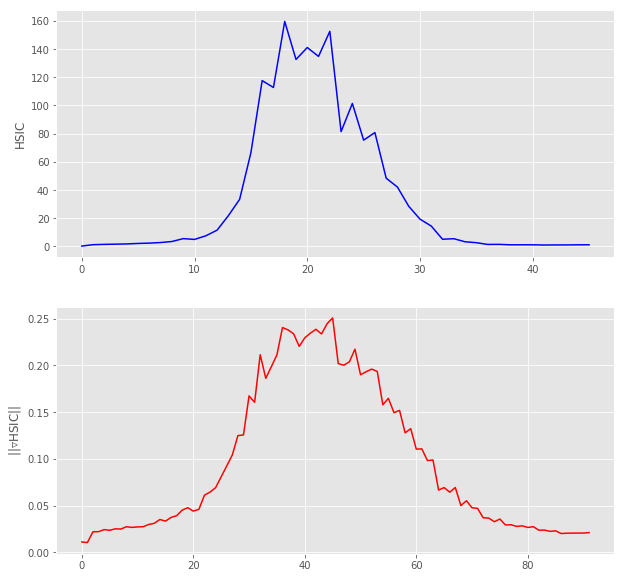

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(lhsic_times_89, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(lhsic_mods_89).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

In [21]:
# Initialize variables
lhsic_times_910 = list()
lhsic_mods_910 = list()
# pbar = tqdm(zip(times1, times2))

for itime2, itime3 in zip(times2, times3):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime2, itime2)) 
    subset2 = xr_dataset.sel(time=slice(itime3, itime3))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)
#     fig, ax = plt.subplots()
    
#     ax.hist(X, bins=100)
#     plt.show()
#     fig, ax = plt.subplots()
    
#     ax.hist(Y, bins=100)
#     plt.show()
    model = 'linear'
    subsample = 4000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods_910.append(lhsic_model.get_mod())
    lhsic_times_910.append(hsic_val)

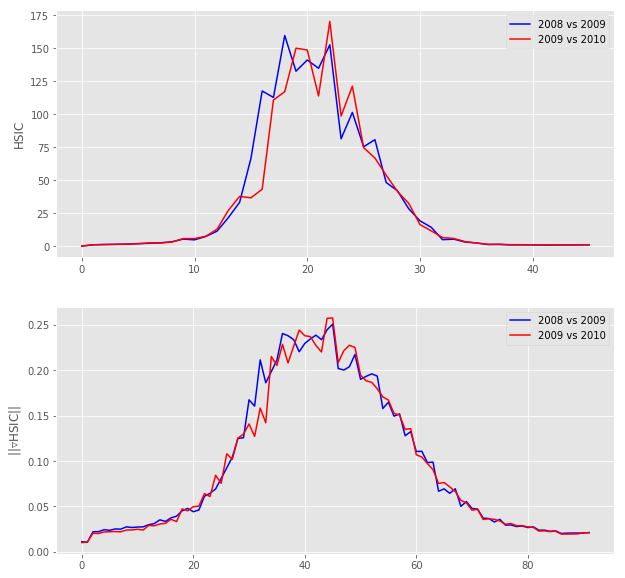

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(lhsic_times_89, label='2008 vs 2009', color='blue')
ax[0].plot(lhsic_times_910, label='2009 vs 2010', color='red')
ax[0].set_ylabel('HSIC')
ax[0].legend()

ax[1].plot(np.hstack(lhsic_mods_89).mean(axis=0), label='2008 vs 2009', color='b')
ax[1].plot(np.hstack(lhsic_mods_910).mean(axis=0), label='2009 vs 2010', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')
ax[1].legend()

plt.show()

#### Russia

In [23]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
lhsic_times_r_89 = list()
lhsic_mods_r_89 = list()
# pbar = tqdm(times)

for itime1, itime2 in zip(times1, times2):
    # Subset region (monthly time cycle)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(itime1, itime1)) 
    subset2 = xr_dataset_r.sel(time=slice(itime2, itime2))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)

    model = 'linear'
    subsample = 4000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods_r_89.append(lhsic_model.get_mod())
    lhsic_times_r_89.append(hsic_val)

CPU times: user 17min 41s, sys: 17min 11s, total: 34min 53s
Wall time: 1min 20s


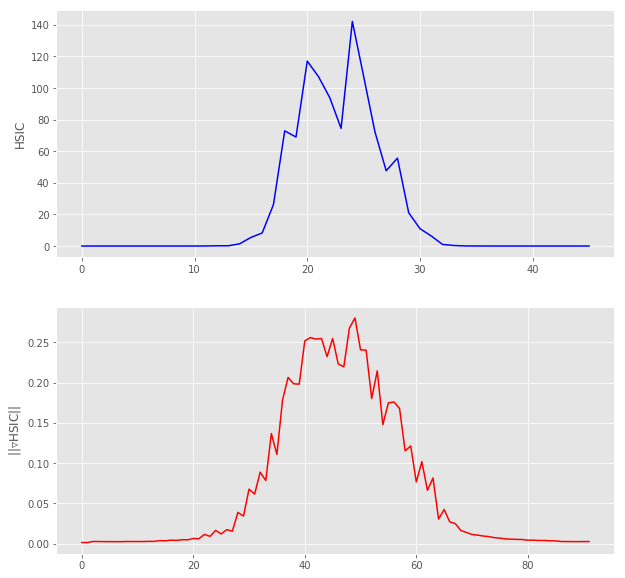

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(lhsic_times_r_89, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(lhsic_mods_r_89).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

In [25]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
lhsic_times_r_910 = list()
lhsic_mods_r_910 = list()
# pbar = tqdm(times)

for itime2, itime3 in zip(times2, times3):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime2, itime2)) 
    subset2 = xr_dataset.sel(time=slice(itime3, itime3))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)

    model = 'linear'
    subsample = 4000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X , Y)
    hsic_val = lhsic_model.get_hsic()
    lhsic_mods_r_910.append(lhsic_model.get_mod())
    lhsic_times_r_910.append(hsic_val)

CPU times: user 17min 37s, sys: 17min 16s, total: 34min 54s
Wall time: 1min 26s


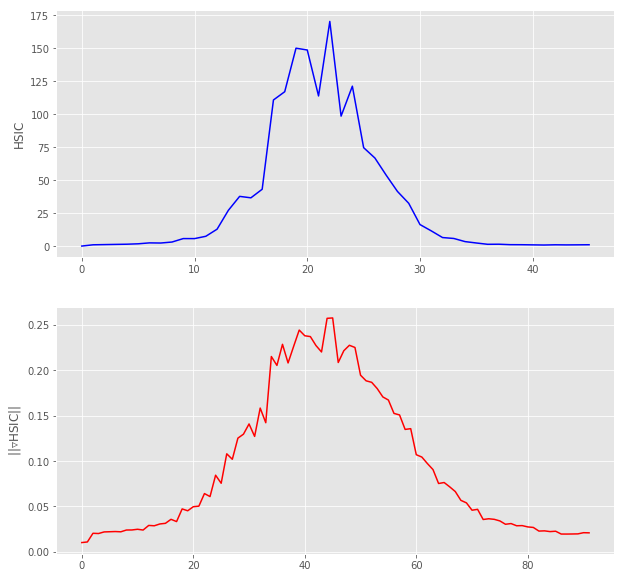

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(lhsic_times_r_910, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(lhsic_mods_r_910).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

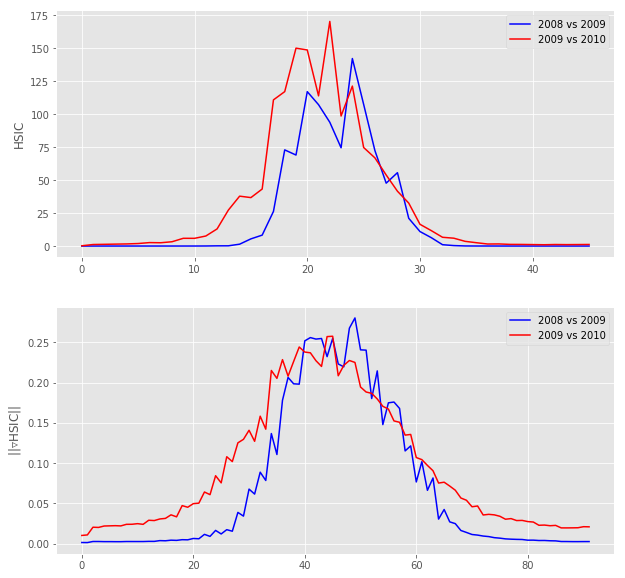

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(lhsic_times_r_89, label='2008 vs 2009', color='blue')
ax[0].plot(lhsic_times_r_910, label='2009 vs 2010', color='red')
ax[0].set_ylabel('HSIC')
ax[0].legend()

ax[1].plot(np.hstack(lhsic_mods_r_89).mean(axis=0), label='2008 vs 2009', color='b')
ax[1].plot(np.hstack(lhsic_mods_r_910).mean(axis=0), label='2009 vs 2010', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')
ax[1].legend()

plt.show()

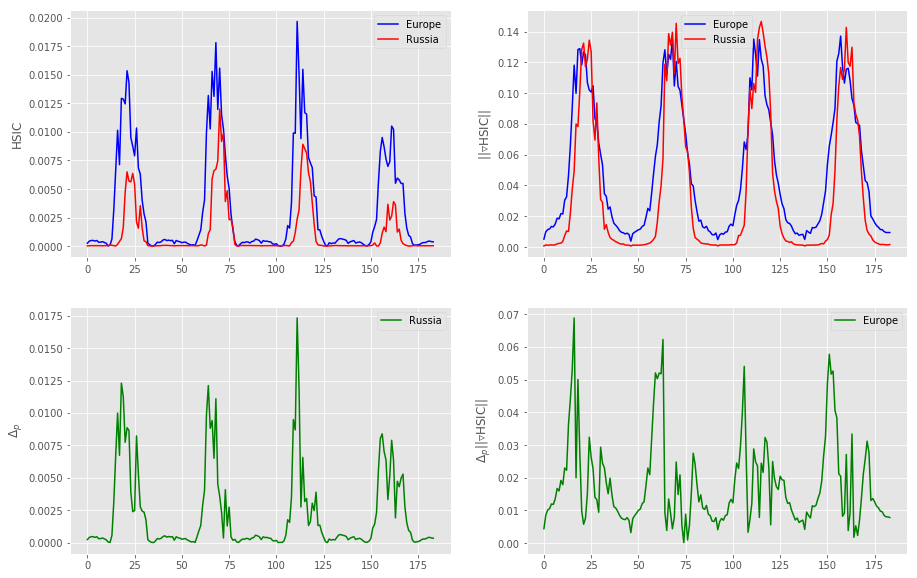

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))


ax[0, 0].plot(lhsic_times, label='Europe', color='blue')
ax[0, 0].plot(lhsic_times_r, label='Russia', color='red')
ax[0, 0].set_ylabel('HSIC')
ax[0, 0].legend()


ax[0, 1].plot(np.hstack(lhsic_mods).mean(axis=0), label='Europe', color='blue')
ax[0, 1].plot(np.hstack(lhsic_mods_r).mean(axis=0), label='Russia', color='red')
ax[0, 1].set_ylabel(r'||$\triangledown$HSIC||')
ax[0, 1].legend()


ax[1, 0].plot(np.abs(np.array(lhsic_times_r) - np.array(lhsic_times)), label='Russia', color='green')
ax[1, 0].set_ylabel(r'$\Delta_p$')
ax[1, 0].legend()


ax[1, 1].plot(np.abs(np.hstack(lhsic_mods).mean(axis=0) - np.hstack(lhsic_mods_r).mean(axis=0)), label='Europe', color='green')
ax[1, 1].set_ylabel(r'$\Delta_p$||$\triangledown$HSIC||')
ax[1, 1].legend()


fig.savefig(figure_path + '1_lhsic_46.png')


plt.show()

### HSIC - RBF Kernel

In [29]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data
times3 = xr_dataset.sel(time=slice('2010', '2010')).time.data

# Get Time stamps
times = xr_dataset.time.data

# Initialize variables
rbfhsic_times_89 = list()
rbfhsic_mods_89 = list()
# pbar = tqdm(zip(times1, times2))

for itime1, itime2 in zip(times1, times2):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime1, itime1)) 
    subset2 = xr_dataset.sel(time=slice(itime2, itime2))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)
#     fig, ax = plt.subplots()
    
#     ax.hist(X, bins=100)
#     plt.show()
#     fig, ax = plt.subplots()
    
#     ax.hist(Y, bins=100)
#     plt.show()
    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    hsic_val = rbfhsic_model.get_hsic()
    rbfhsic_mods_89.append(rbfhsic_model.get_mod())
    rbfhsic_times_89.append(hsic_val)

CPU times: user 27min 1s, sys: 23min 30s, total: 50min 31s
Wall time: 2min 18s


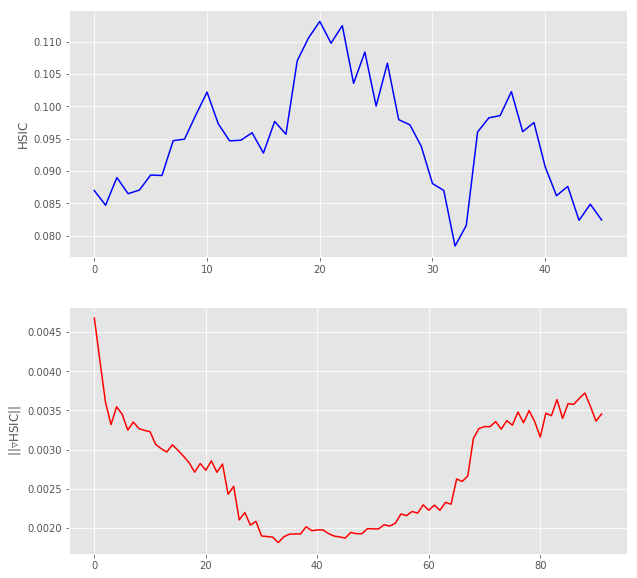

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(rbfhsic_times_89, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(rbfhsic_mods_89).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

In [31]:
# Initialize variables
rbfhsic_times_910 = list()
rbfhsic_mods_910 = list()
# pbar = tqdm(zip(times1, times2))

for itime2, itime3 in zip(times2, times3):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime2, itime2)) 
    subset2 = xr_dataset.sel(time=slice(itime3, itime3))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)
#     fig, ax = plt.subplots()
    
#     ax.hist(X, bins=100)
#     plt.show()
#     fig, ax = plt.subplots()
    
#     ax.hist(Y, bins=100)
#     plt.show()
    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    hsic_val = rbfhsic_model.get_hsic()
    rbfhsic_mods_910.append(rbfhsic_model.get_mod())
    rbfhsic_times_910.append(hsic_val)

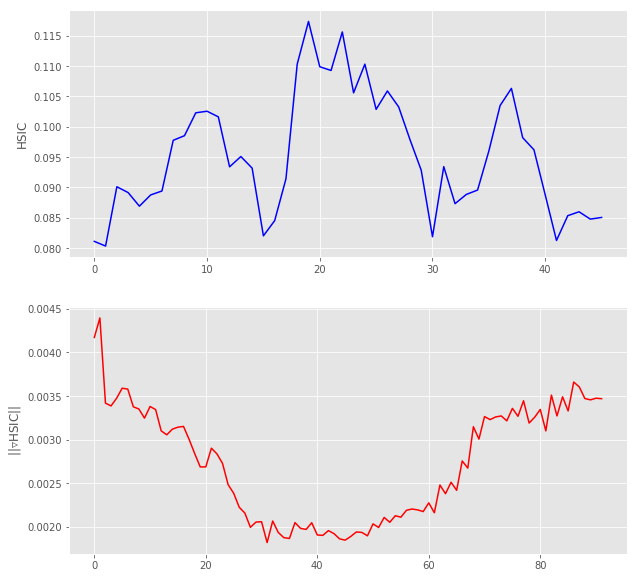

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(rbfhsic_times_910, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(rbfhsic_mods_910).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

#### Russia

In [33]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
rbfhsic_times_r_89 = list()
rbfhsic_mods_r_89 = list()
# pbar = tqdm(times)

for itime1, itime2 in zip(times1, times2):
    # Subset region (monthly time cycle)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(itime1, itime1)) 
    subset2 = xr_dataset_r.sel(time=slice(itime2, itime2))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)

    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    hsic_val = rbfhsic_model.get_hsic()
    rbfhsic_mods_r_89.append(rbfhsic_model.get_mod())
    rbfhsic_times_r_89.append(hsic_val)

CPU times: user 28min 31s, sys: 23min 15s, total: 51min 47s
Wall time: 2min 15s


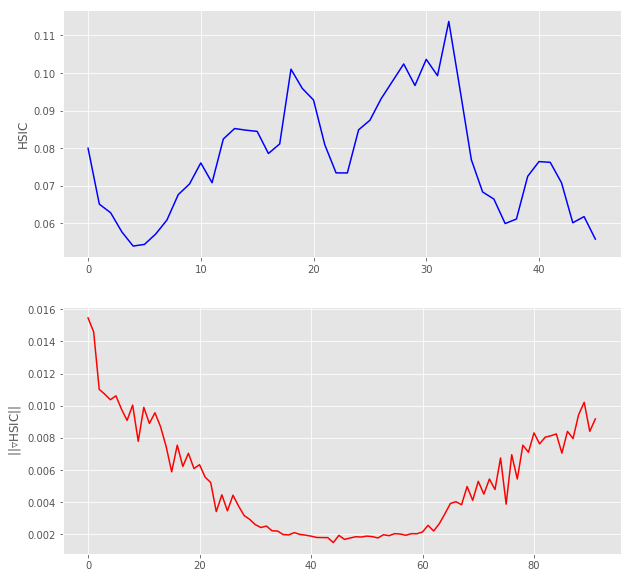

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))


ax[0].plot(rbfhsic_times_r_89, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(rbfhsic_mods_r_89).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

In [35]:
%%time

times1 = xr_dataset.sel(time=slice('2008', '2008')).time.data
times2 = xr_dataset.sel(time=slice('2009', '2009')).time.data

# Get Time stamps
times = xr_dataset_r.time.data

# Initialize variables
rbfhsic_times_r_910 = list()
rbfhsic_mods_r_910 = list()
# pbar = tqdm(times)

for itime2, itime3 in zip(times2, times3):
    
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(itime2, itime2)) 
    subset2 = xr_dataset.sel(time=slice(itime3, itime3))
    
    subsample = 4000
    normalize = False
    variables = [
        'gross_primary_productivity',
        'gross_primary_productivity',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset, subset2)

    model = 'rbf'
    subsample = 4000

    rbfhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    rbfhsic_model.fit_model(X , Y)
    hsic_val = rbfhsic_model.get_hsic()
    rbfhsic_mods_r_910.append(rbfhsic_model.get_mod())
    rbfhsic_times_r_910.append(hsic_val)

CPU times: user 25min 52s, sys: 23min 29s, total: 49min 21s
Wall time: 2min 15s


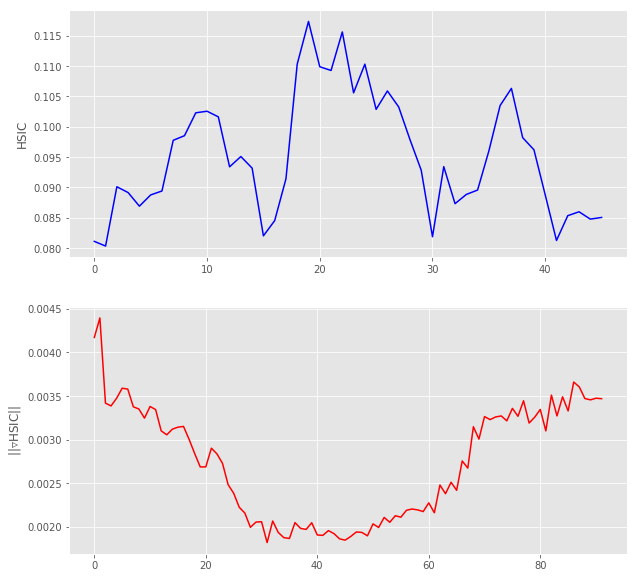

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(rbfhsic_times_r_910, label='HSIC', color='blue')
ax[0].set_ylabel('HSIC')


ax[1].plot(np.hstack(rbfhsic_mods_r_910).mean(axis=0), label=r'||$\triangledown$HSIC||', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')


plt.show()

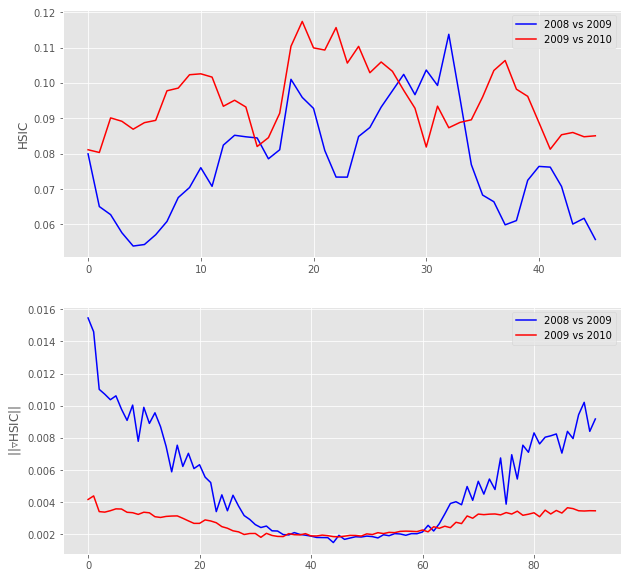

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(rbfhsic_times_r_89, label='2008 vs 2009', color='blue')
ax[0].plot(rbfhsic_times_r_910, label='2009 vs 2010', color='red')
ax[0].set_ylabel('HSIC')
ax[0].legend()

ax[1].plot(np.hstack(rbfhsic_mods_r_89).mean(axis=0), label='2008 vs 2009', color='b')
ax[1].plot(np.hstack(rbfhsic_mods_r_910).mean(axis=0), label='2009 vs 2010', color='r')
ax[1].set_ylabel(r'||$\triangledown$HSIC||')
ax[1].legend()

plt.show()

In [105]:
%%time
# Experimental Parameters
years = ['2''2009', '2010', '2011']
variables = [
    'gross_primary_productivity',
    'root_moisture',
]

subsample = 4000
normalize = True
model = 'linear'
subsample = 1000

lhsic_times = dict()
lhsic_mods = dict()

for iyear in years:
    print(f"Year: {iyear}")
    
    # Initialize storage variables
    lhsic_times[iyear] = list()
    lhsic_mods[iyear] = list()
    
    # =====================
    # Group by Months
    # =====================
    xr_sub = xr_dataset.sel(time=slice(str(iyear), str(iyear)))
    times = xr_sub.time.data
    for itime in times:
        print(itime)
        # Initialize Feature-Getter Class
        data_features = GetXYData(
            subsample=subsample,
            normalize=normalize,
            variables=variables,
        )
        
        # Get Features
        X, Y, lat, lon = data_features.set_XY(xr_sub.sel(time=itime))
        
        # Initialize Model
        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )
        
        # Fit HSIC model to data
        lhsic_model.fit_model(X , Y)
        hsic_val = lhsic_model.get_hsic()
        hsic_mod = lhsic_model.get_mod().mean(axis=0)
#         print(X.shape, Y.shape)
#         print(hsic_val)
#         print(hsic_mod.shape)
        lhsic_mods[iyear].append(hsic_mod)
        lhsic_times[iyear].append(hsic_val)
        break
#         break
#     break

Year: 2009
2009-01-05T00:00:00.000000000


KeyError: 'lat'

In [55]:
np.concatenate(lhsic_mods['2009'])

(46,)

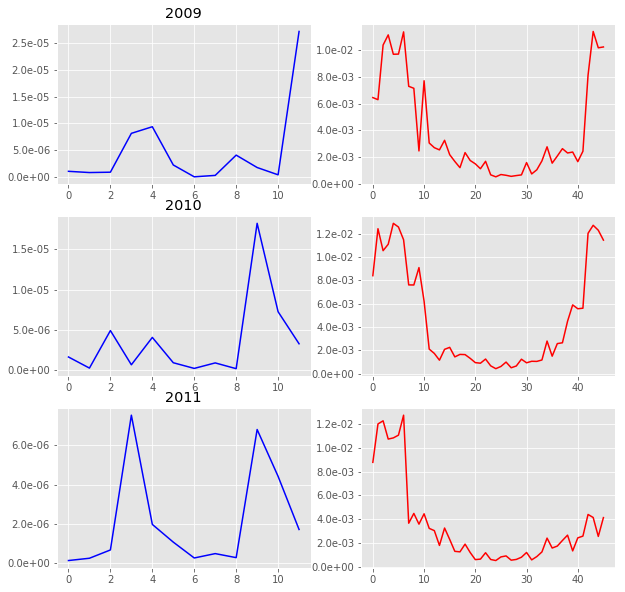

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times[iyear], label='HSIC', color='blue')
    iax[1].plot(np.concatenate(lhsic_mods[iyear]), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 9.5e-6])
#     iax[1].set_ylim([0, 2.0e-3])
plt.show()

In [182]:
%%time
years = ['2009', '2010', '2011']
lhsic_times = dict()
lhsic_mods = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(str(iyear), str(iyear))).resample(time='2W').mean(dim='time')
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times[iyear] = list()
    lhsic_mods[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'linear'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods[iyear].append(lhsic_model.get_mod())
        lhsic_times[iyear].append(hsic_val)


2009
2010
2011
CPU times: user 27min 35s, sys: 28min 55s, total: 56min 31s
Wall time: 1min 59s


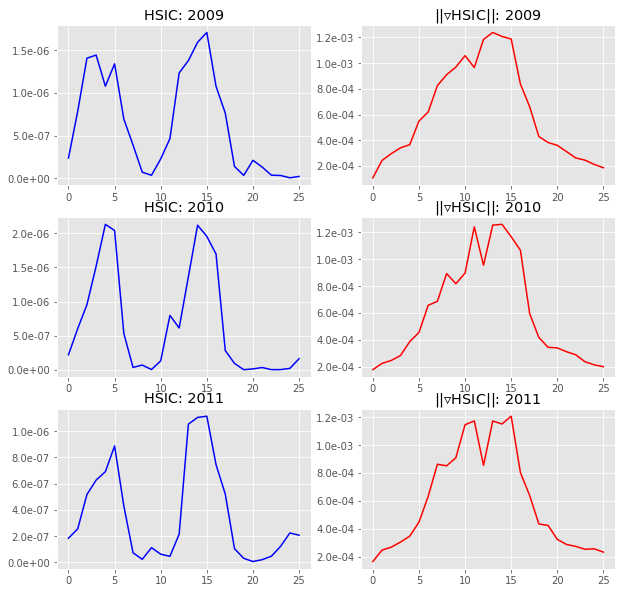

In [184]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(f"HSIC: {iyear}")
    iax[1].set_title(fr"||$\triangledown$HSIC||: {iyear}")
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 8.0e-7])
#     iax[1].set_ylim([0, 1.0e-3])
plt.show()

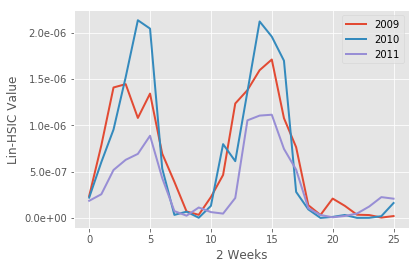

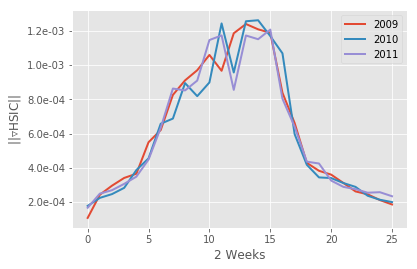

In [185]:
fig, ax = plt.subplots()

ax.plot(lhsic_times['2009'], label='2009', linewidth=2)
ax.plot(lhsic_times['2010'], label='2010', linewidth=2)
ax.plot(lhsic_times['2011'], label='2011', linewidth=2)

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot(np.array(lhsic_mods['2009']).squeeze().mean(axis=1), label='2009', linewidth=2)
ax.plot(np.array(lhsic_mods['2010']).squeeze().mean(axis=1), label='2010', linewidth=2)
ax.plot(np.array(lhsic_mods['2011']).squeeze().mean(axis=1), label='2011', linewidth=2)

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

#### Russia

In [186]:
%%time
years = ['2009', '2010', '2011']
lhsic_times_r = dict()
lhsic_mods_r = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(str(iyear), str(iyear))).resample(time='2W').mean(dim='time')
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times_r[iyear] = list()
    lhsic_mods_r[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'linear'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods_r[iyear].append(lhsic_model.get_mod())
        lhsic_times_r[iyear].append(hsic_val)

2009
2010
2011
CPU times: user 27min 30s, sys: 28min 14s, total: 55min 45s
Wall time: 1min 58s


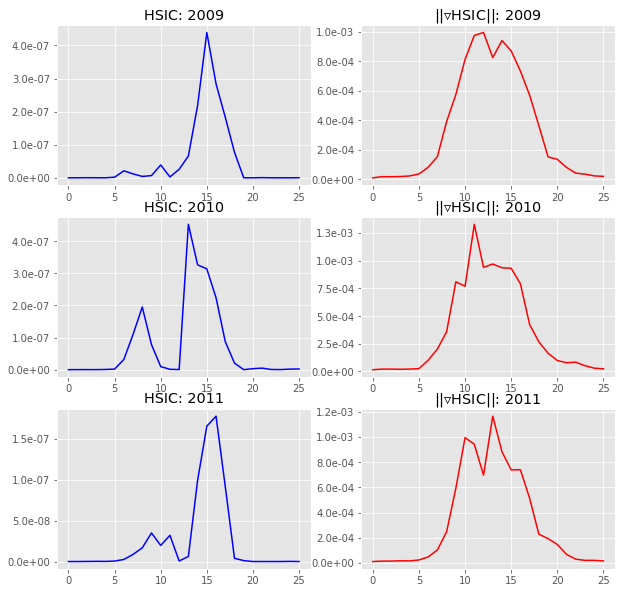

In [187]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times_r[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods_r[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(f"HSIC: {iyear}")
    iax[1].set_title(fr"||$\triangledown$HSIC||: {iyear}")
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 1.6e-7])
#     iax[1].set_ylim([0, 1.0e-3])
plt.show()

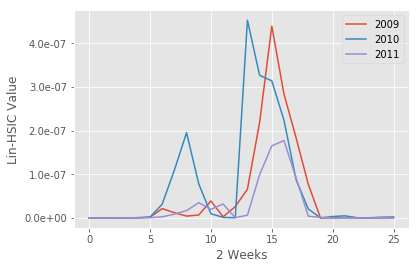

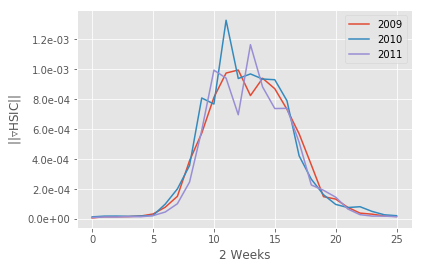

In [188]:
fig, ax = plt.subplots()

ax.plot(lhsic_times_r['2009'], label='2009')
ax.plot(lhsic_times_r['2010'], label='2010')
ax.plot(lhsic_times_r['2011'], label='2011')

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot(np.array(lhsic_mods_r['2009']).squeeze().mean(axis=1), label='2009')
ax.plot(np.array(lhsic_mods_r['2010']).squeeze().mean(axis=1), label='2010')
ax.plot(np.array(lhsic_mods_r['2011']).squeeze().mean(axis=1), label='2011')

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

## Experiment II - RBF HSIC

In [153]:
%%time
years = ['2009', '2010', '2011']
lhsic_times = dict()
lhsic_mods = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(str(iyear), str(iyear)))
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times[iyear] = list()
    lhsic_mods[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rbf'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods[iyear].append(lhsic_model.get_mod())
        lhsic_times[iyear].append(hsic_val)


2009
2010
2011
CPU times: user 1h 14min 10s, sys: 1h 7min 21s, total: 2h 21min 32s
Wall time: 5min 20s


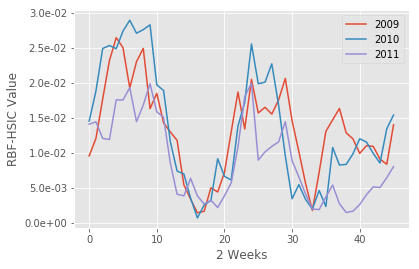

In [154]:
fig, ax = plt.subplots()

ax.plot(lhsic_times['2009'], label='2009')
ax.plot(lhsic_times['2010'], label='2010')
ax.plot(lhsic_times['2011'], label='2011')

ax.set_ylabel('RBF-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

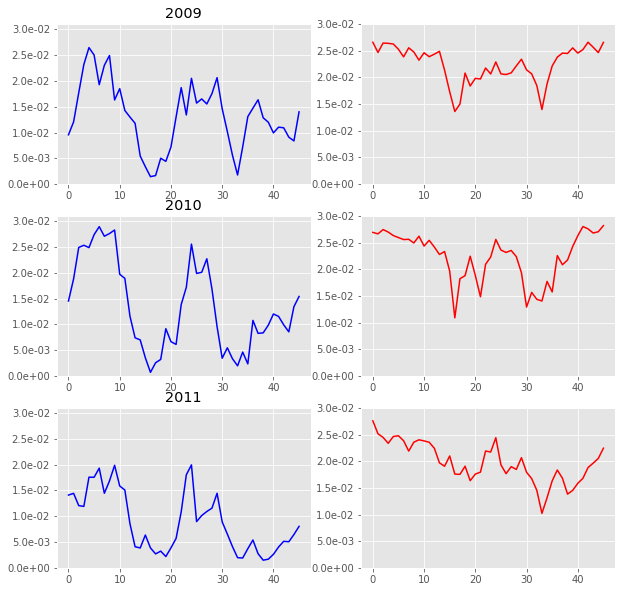

In [155]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='red')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
#     Set YLims
    iax[0].set_ylim([0, 3.1e-2])
    iax[1].set_ylim([0, 3.0e-2])
plt.show()

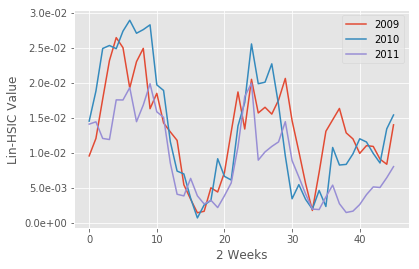

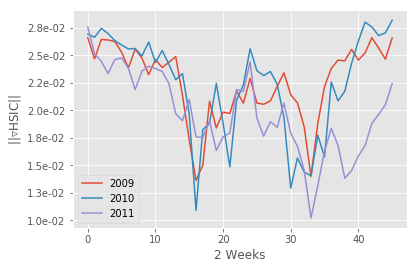

In [156]:
fig, ax = plt.subplots()

ax.plot(lhsic_times['2009'], label='2009')
ax.plot(lhsic_times['2010'], label='2010')
ax.plot(lhsic_times['2011'], label='2011')

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot(np.array(lhsic_mods['2009']).squeeze().mean(axis=1), label='2009')
ax.plot(np.array(lhsic_mods['2010']).squeeze().mean(axis=1), label='2010')
ax.plot(np.array(lhsic_mods['2011']).squeeze().mean(axis=1), label='2011')

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

### Russia

In [157]:
%%time
years = ['2009', '2010', '2011']
rbfhsic_times_r = dict()
rbfhsic_mods_r = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(str(iyear), str(iyear)))
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    rbfhsic_times_r[iyear] = list()
    rbfhsic_mods_r[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rbf'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        rbfhsic_mods_r[iyear].append(lhsic_model.get_mod())
        rbfhsic_times_r[iyear].append(hsic_val)

2009
2010
2011
CPU times: user 1h 19min 15s, sys: 1h 5min 49s, total: 2h 25min 5s
Wall time: 5min 29s


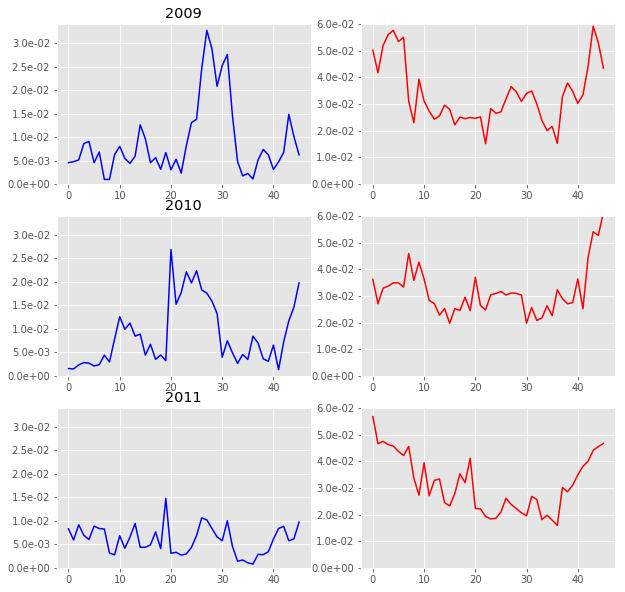

In [166]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(rbfhsic_times_r[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(rbfhsic_mods_r[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
    iax[0].set_ylim([0, 3.4e-2])
    iax[1].set_ylim([0, 6.0e-2])
plt.show()

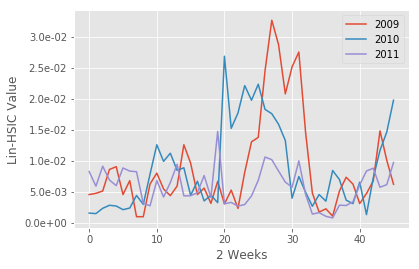

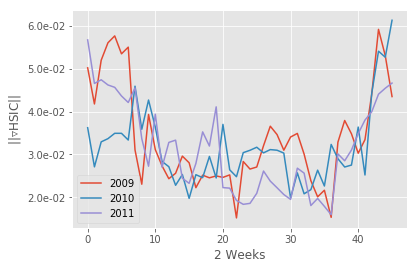

In [159]:
fig, ax = plt.subplots()

ax.plot(rbfhsic_times_r['2009'], label='2009')
ax.plot(rbfhsic_times_r['2010'], label='2010')
ax.plot(rbfhsic_times_r['2011'], label='2011')

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot(np.array(rbfhsic_mods_r['2009']).squeeze().mean(axis=1), label='2009')
ax.plot(np.array(rbfhsic_mods_r['2010']).squeeze().mean(axis=1), label='2010')
ax.plot(np.array(rbfhsic_mods_r['2011']).squeeze().mean(axis=1), label='2011')

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

## Experiment II - RFF HSIC

In [141]:
%%time
years = ['2009', '2010', '2011']
rffhsic_times = dict()
rffhsic_mods = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(str(iyear), str(iyear)))
    dates = subset.time.data

    subsample = None
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    rffhsic_times[iyear] = list()
    rffhsic_mods[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rff'
        subsample = 4000
        n_features = 2000

        rffhsic_model = HSICDependence(
            model=model,
            subsample=subsample,
            n_features=n_features,
        )

        # Fit HSIC model to data
        rffhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = rffhsic_model.get_hsic()
        rffhsic_mods[iyear].append(rffhsic_model.get_mod())
        rffhsic_times[iyear].append(hsic_val)


2009
2010
2011
CPU times: user 15h 34min 45s, sys: 3h 51min 14s, total: 19h 26min
Wall time: 1h 14min 36s


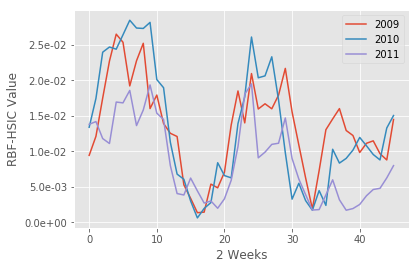

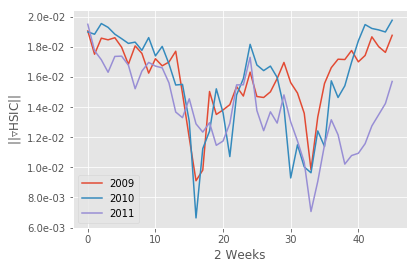

In [169]:
fig, ax = plt.subplots()

ax.plot(rffhsic_times['2009'], label='2009')
ax.plot(rffhsic_times['2010'], label='2010')
ax.plot(rffhsic_times['2011'], label='2011')

ax.set_ylabel('RBF-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()


fig, ax = plt.subplots()

ax.plot(np.array(rffhsic_mods['2009']).squeeze().mean(axis=1), label='2009')
ax.plot(np.array(rffhsic_mods['2010']).squeeze().mean(axis=1), label='2010')
ax.plot(np.array(rffhsic_mods['2011']).squeeze().mean(axis=1), label='2011')

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

In [143]:
%%time
years = ['2009', '2010', '2011']
rffhsic_times_r = dict()
rffhsic_mods_r = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(str(iyear), str(iyear)))
    dates = subset.time.data

    subsample = None
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    rffhsic_times_r[iyear] = list()
    rffhsic_mods_r[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rff'
        subsample = 4000

        rffhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        rffhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = rffhsic_model.get_hsic()
        rffhsic_mods_r[iyear].append(rffhsic_model.get_mod())
        rffhsic_times_r[iyear].append(hsic_val)

2009
2010
2011
CPU times: user 2h 40min 15s, sys: 2h 2min 18s, total: 4h 42min 33s
Wall time: 15min 14s


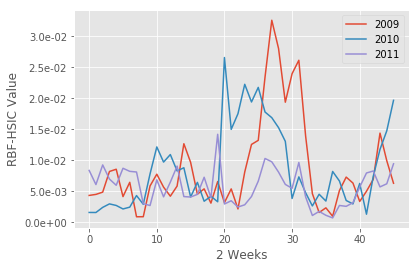

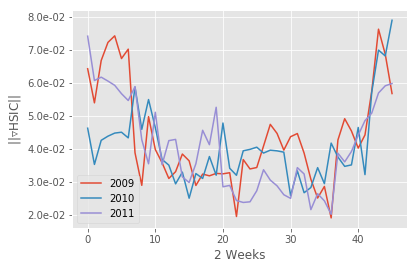

In [170]:
fig, ax = plt.subplots()

ax.plot(rffhsic_times_r['2009'], label='2009')
ax.plot(rffhsic_times_r['2010'], label='2010')
ax.plot(rffhsic_times_r['2011'], label='2011')

ax.set_ylabel('RBF-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots()

ax.plot(np.array(rffhsic_mods_r['2009']).squeeze().mean(axis=1), label='2009')
ax.plot(np.array(rffhsic_mods_r['2010']).squeeze().mean(axis=1), label='2010')
ax.plot(np.array(rffhsic_mods_r['2011']).squeeze().mean(axis=1), label='2011')

ax.set_ylabel(r'||$\triangledown$HSIC||')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

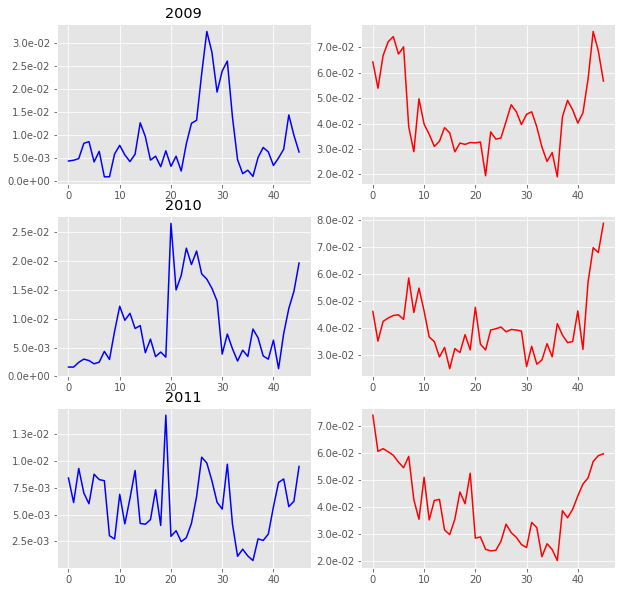

In [146]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(rffhsic_times_r[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(rffhsic_mods_r[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 1.6e-7])
#     iax[1].set_ylim([0, 1.0e-3])
plt.show()

## Experiment I - Linear HSIC 

In [33]:
%%time
subsample = 1000
normalize = True
variables = [
    'gross_primary_productivity',
    'root_moisture',
]

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize,
    variables=variables,
)

# Extract variables and coordiantes
subset = xr_dataset.sel(time=slice(str(2010), str(2010))).resample(time='1MS').mean()
dates = xr_dataset.time.data
X, Y, lat, lon = data_features.set_XY(subseet)

TypeError: set_XY() missing 1 required positional argument: 'xr_data'

In [29]:
X.shape

(10000, 12)

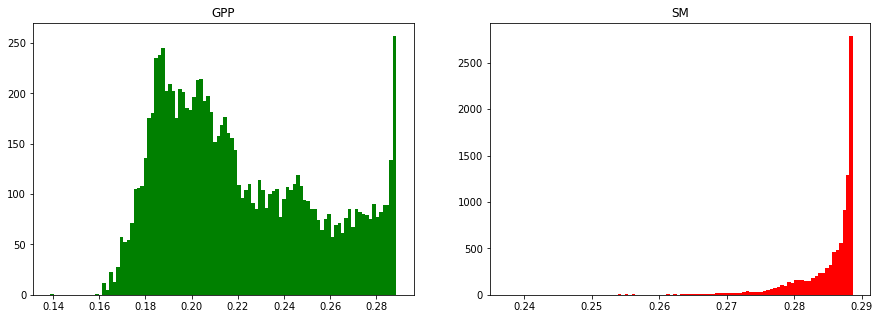

In [30]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [31]:
hsic_times = list()


In [32]:
for itime in range(X.shape[1]):
    
    model = 'linear'
    subsample = 1000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X[:,itime][:, None] , Y[:, itime][:, None])
    hsic_val = lhsic_model.get_hsic()
    hsic_times.append(hsic_val)
    print(hsic_val)

2.0985794328710917e-06
6.430891433821638e-06
7.034077064377727e-06
3.2700826923088195e-07
1.9161674287686338e-08
3.418579219780041e-06
9.137667431546983e-06
6.246483283988974e-06
2.539341034298691e-07
1.607075377130979e-07
1.0102022421726106e-08
7.140620835453669e-07


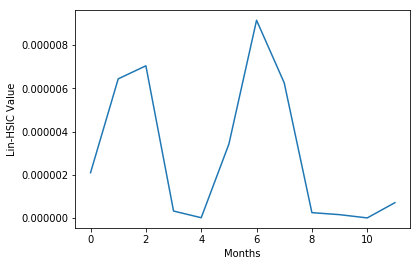

In [36]:
fig, ax = plt.subplots()

ax.plot(hsic_times)
ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('Months')
plt.show()

In [52]:
%%time

model = 'linear'
subsample = 1000

lhsic_model = HSICDependence(
    model=model,
    subsample=subsample
)

# Fit HSIC model to data
lhsic_model.fit_model(X, Y)

CPU times: user 2min 31s, sys: 20.6 s, total: 2min 52s
Wall time: 8.06 s


In [53]:
print(f"HSIC: {lhsic_model.get_hsic():.4f}")

HSIC: 0.0004


In [58]:
%%time
derX['lhsic'], derY['lhsic'] = lhsic_model.get_derivative()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 296 µs


In [59]:
%%time
mod_sens['lhsic'] = lhsic_model.get_mod()
ang_sens['lhsic'] = lhsic_model.get_angle()

CPU times: user 97.7 ms, sys: 3.01 ms, total: 101 ms
Wall time: 99.8 ms


In [60]:
print(X.shape, ang_sens['lhsic'].shape)

(10000, 138) (10000, 138)


### Scatter Plot - Normalized Data

In [ ]:
plot_sens_scatters(X, Y, mod_sens['lhsic'], ang_sens['lhsic'], year=year, model='lhsic', mean=True, normed=True)

### Convert Data to Xarray

In [27]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['lhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


## Maps

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


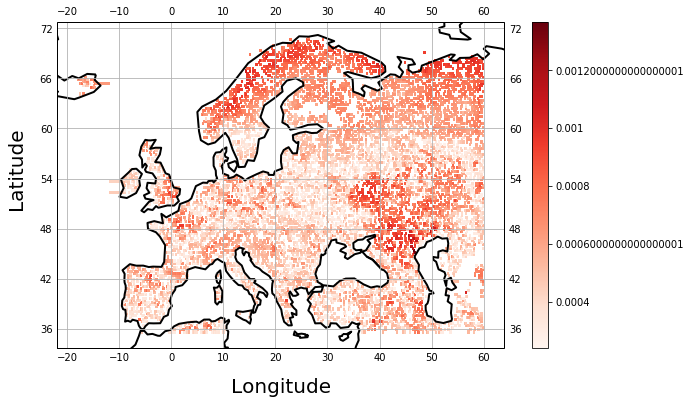

In [28]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

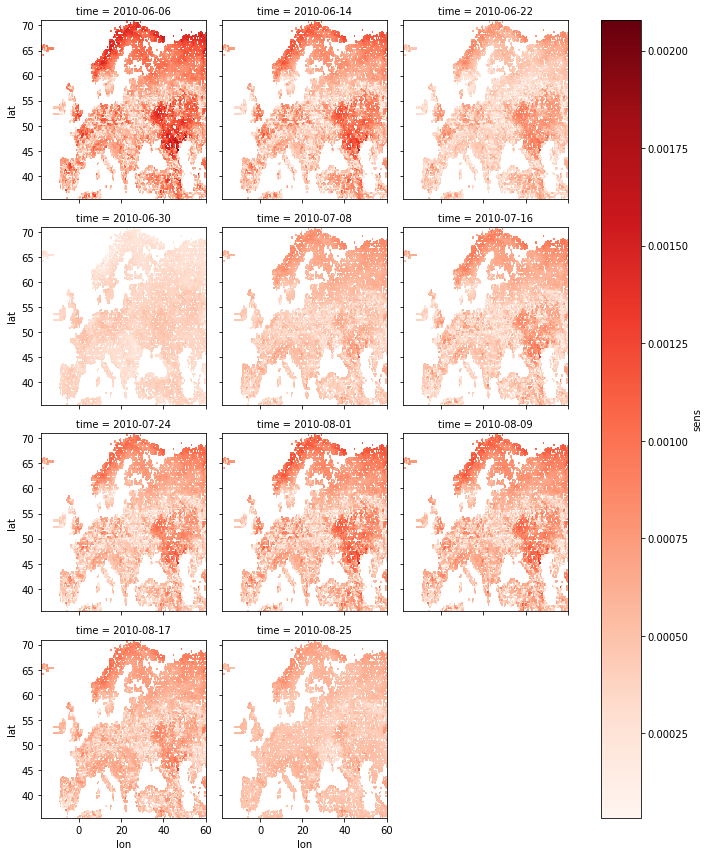

In [29]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=False)

### Angle

In [30]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['lhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['lhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.23 s, sys: 35.2 ms, total: 1.26 s
Wall time: 1.26 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


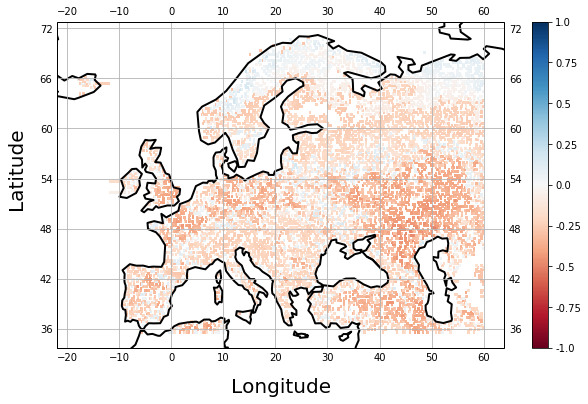

In [32]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

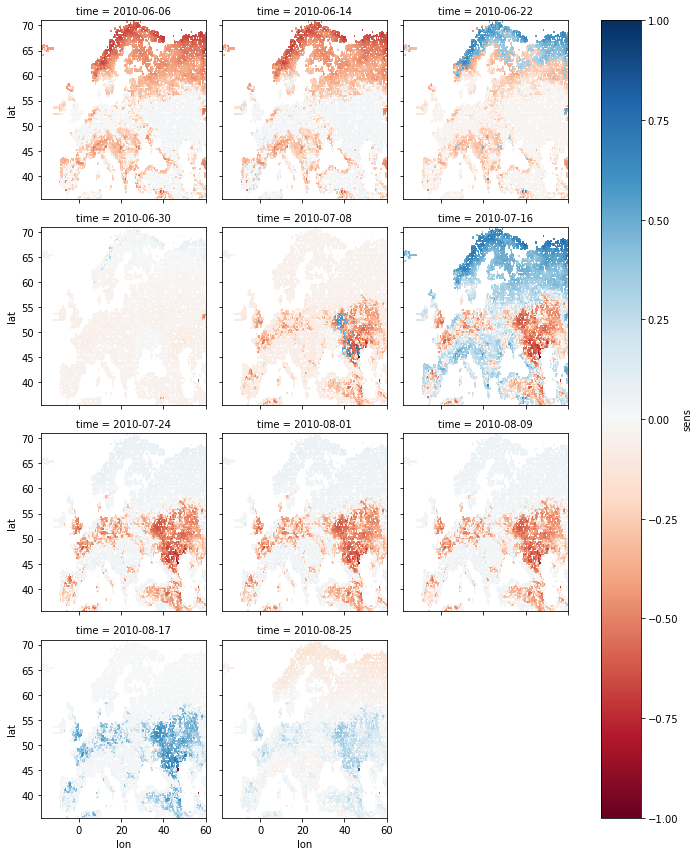

In [34]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=False)

## Experiment II - HSIC (RBF Kernel)

In [55]:
subsample = 10000
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


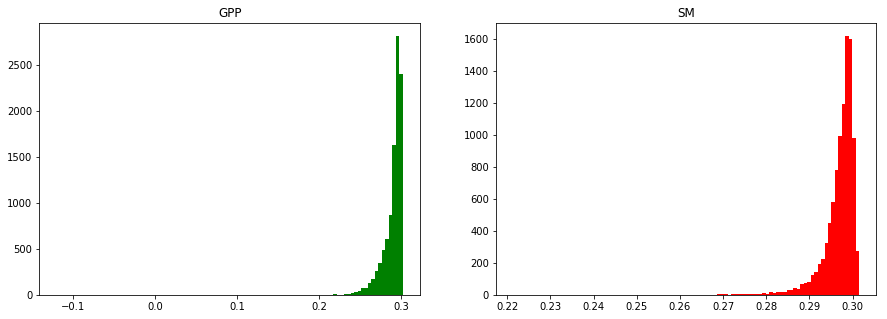

In [56]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [57]:
%%time

model = 'rbf'
subsample = 1000

hsic_model = HSICDependence(
    model=model,
    subsample=subsample,
)

# Fit HSIC model to data
hsic_model.fit_model(X, Y)

CPU times: user 2min 26s, sys: 32.4 s, total: 2min 58s
Wall time: 9.38 s


In [59]:
print(f"HSIC: {hsic_model.get_hsic():.4f}")

HSIC: 0.0065


In [58]:
derX['hsic'], derY['hsic'] = hsic_model.get_derivative()

In [60]:
mod_sens['hsic'] = hsic_model.get_mod()
ang_sens['hsic'] = hsic_model.get_angle()

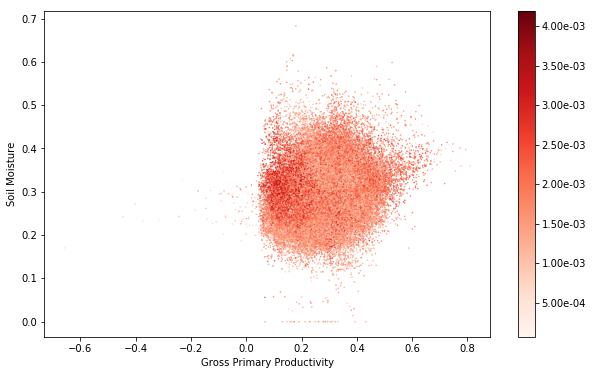

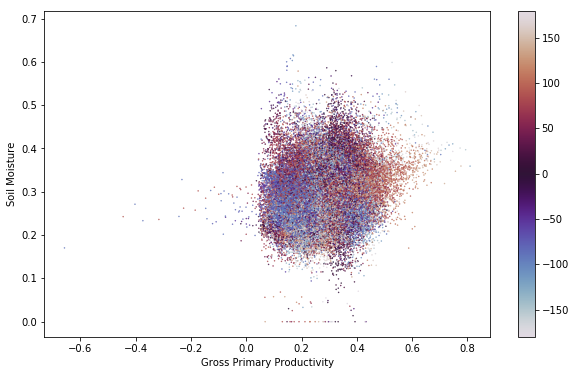

In [61]:
plot_sens_scatters(X, Y, mod_sens['hsic'], ang_sens['hsic'], year=year, model='hsic', mean=False, normed=True)

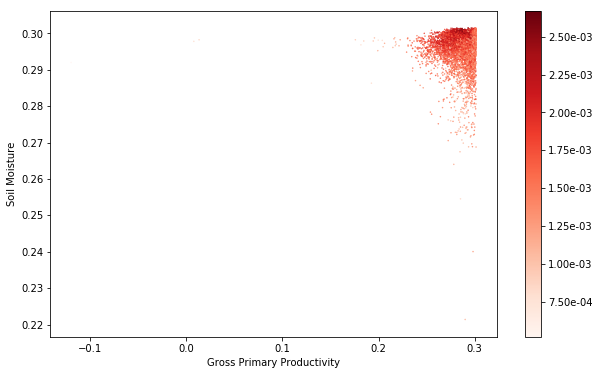

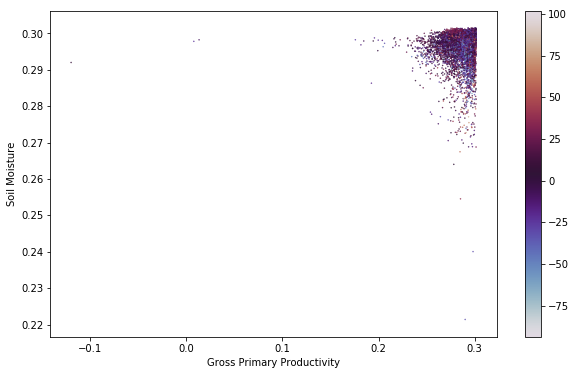

In [62]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['hsic'].mean(axis=1), ang_sens['hsic'].mean(axis=1), year=year, model='hsic', mean=True, normed=True)

In [63]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['hsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


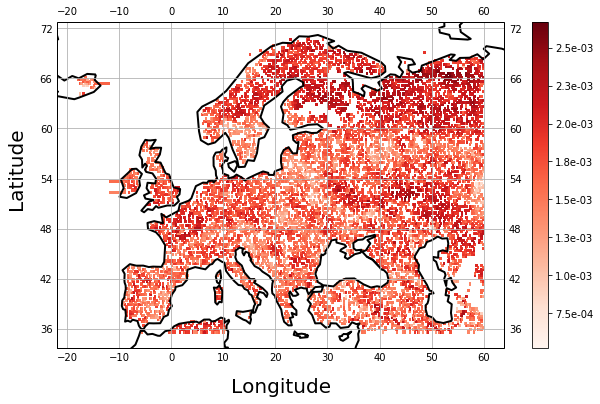

In [64]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

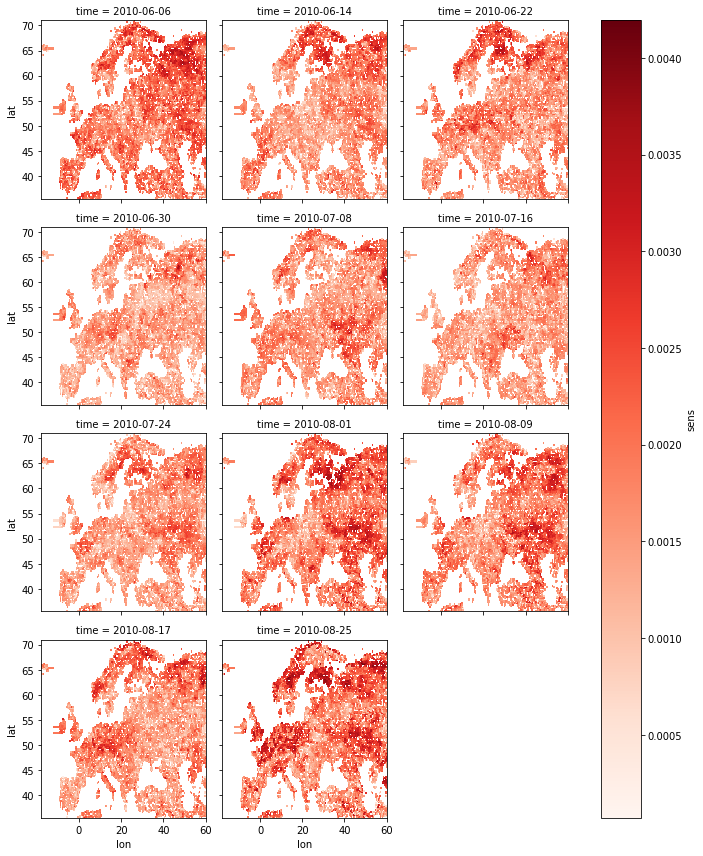

In [65]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=False)

In [66]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['hsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['hsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.15 s, sys: 24.9 ms, total: 1.17 s
Wall time: 1.17 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


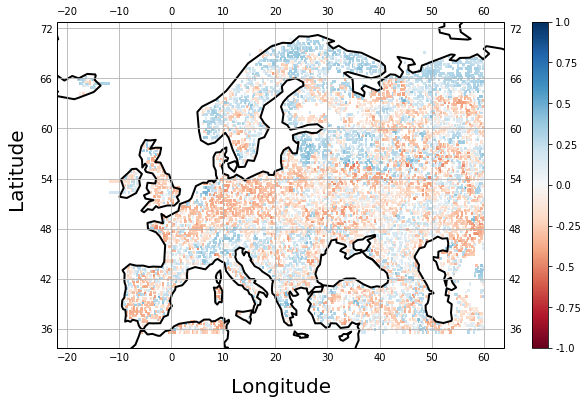

In [67]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

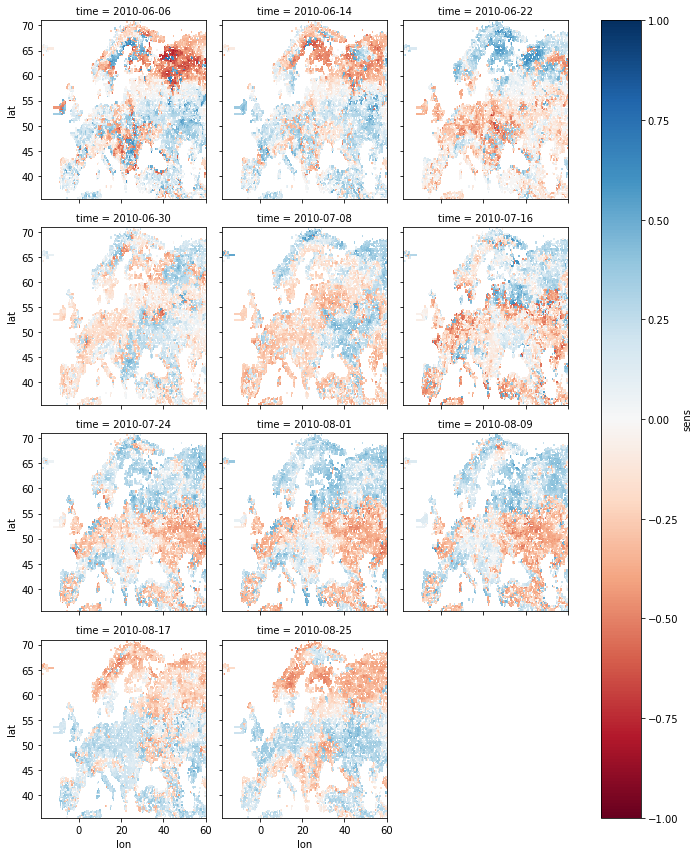

In [68]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=False)

## Experiment III - Randomized HSIC

In [35]:
subsample = None
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

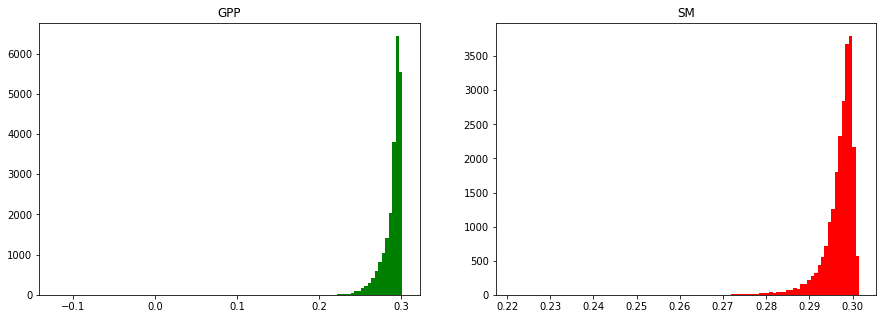

In [36]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [37]:
%%time

model = 'rff'
subsample = 1000
n_features = 2000

rhsic_model = HSICDependence(
    model=model,
    subsample=subsample,
    n_features=n_features
)

# Fit HSIC model to data
rhsic_model.fit_model(X, Y)

CPU times: user 53.1 s, sys: 45.9 s, total: 1min 38s
Wall time: 23.1 s


In [38]:
print(f"RHSIC: {rhsic_model.get_hsic():.4f}")

RHSIC: 0.0066


In [39]:
%%time
derX['rhsic'], derY['rhsic'] = rhsic_model.get_derivative()

CPU times: user 15min 32s, sys: 17min 48s, total: 33min 21s
Wall time: 1min 31s


In [40]:
%%time
mod_sens['rhsic'] = rhsic_model.get_mod()
ang_sens['rhsic'] = rhsic_model.get_angle()

CPU times: user 18.3 ms, sys: 6.15 ms, total: 24.4 ms
Wall time: 24.1 ms


### Scatter Plot - Normalized Data

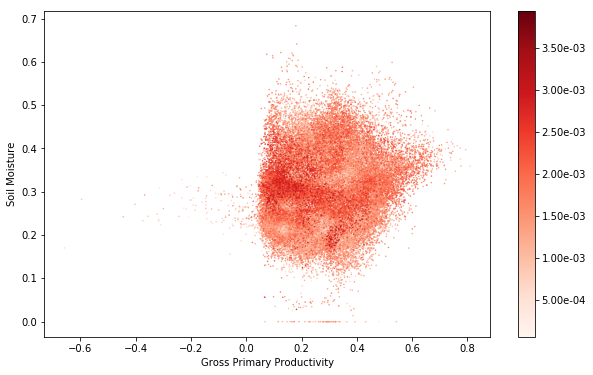

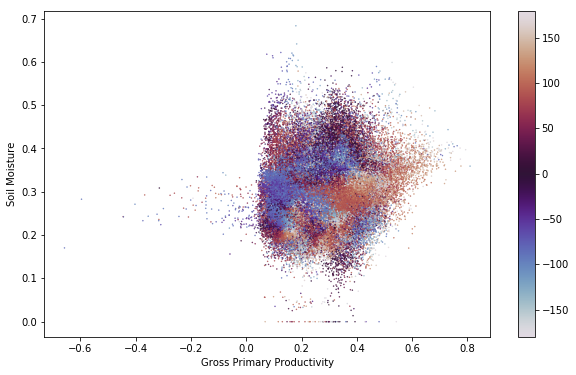

In [41]:
plot_sens_scatters(X, Y, mod_sens['rhsic'], ang_sens['rhsic'], year=year, model='rhsic', mean=False, normed=True)

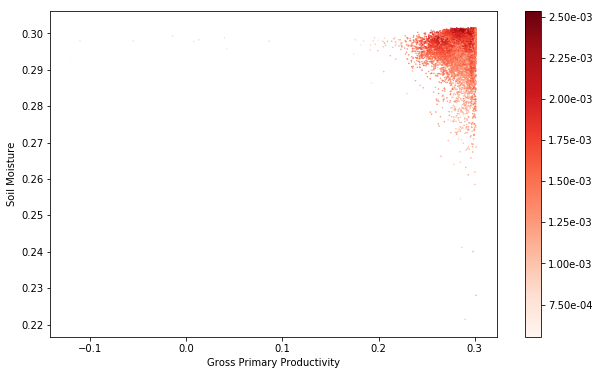

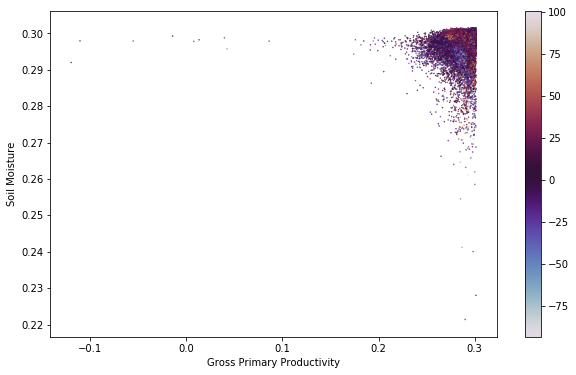

In [42]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['rhsic'].mean(axis=1), ang_sens['rhsic'].mean(axis=1), year=year, model='rhsic', mean=True, normed=True)

In [43]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['rhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


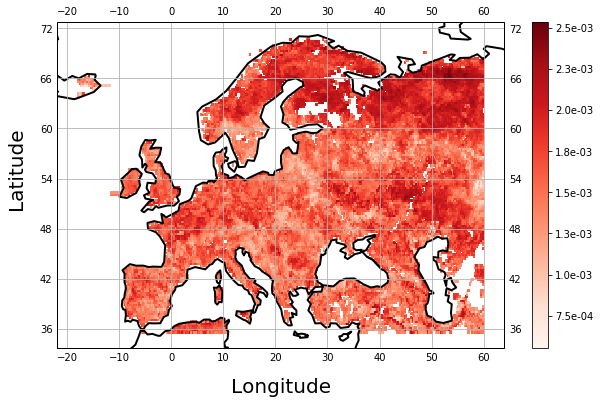

In [50]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

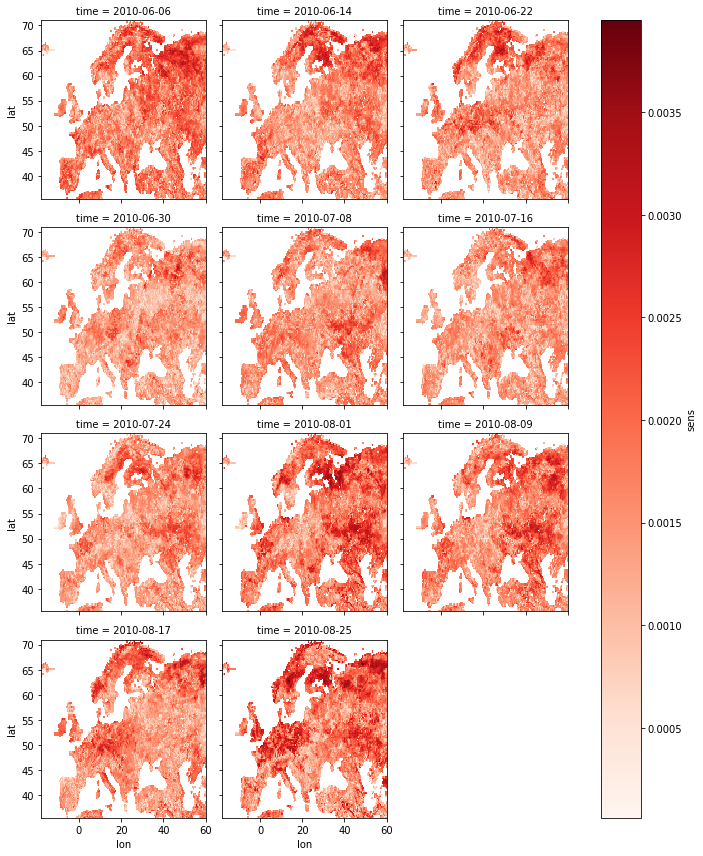

In [51]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=False)

In [52]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['rhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['rhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(23090, 11) (23090, 11)
CPU times: user 1.21 s, sys: 42.2 ms, total: 1.26 s
Wall time: 1.25 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


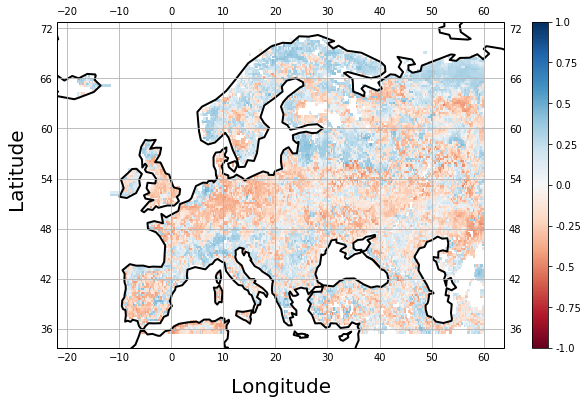

In [53]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

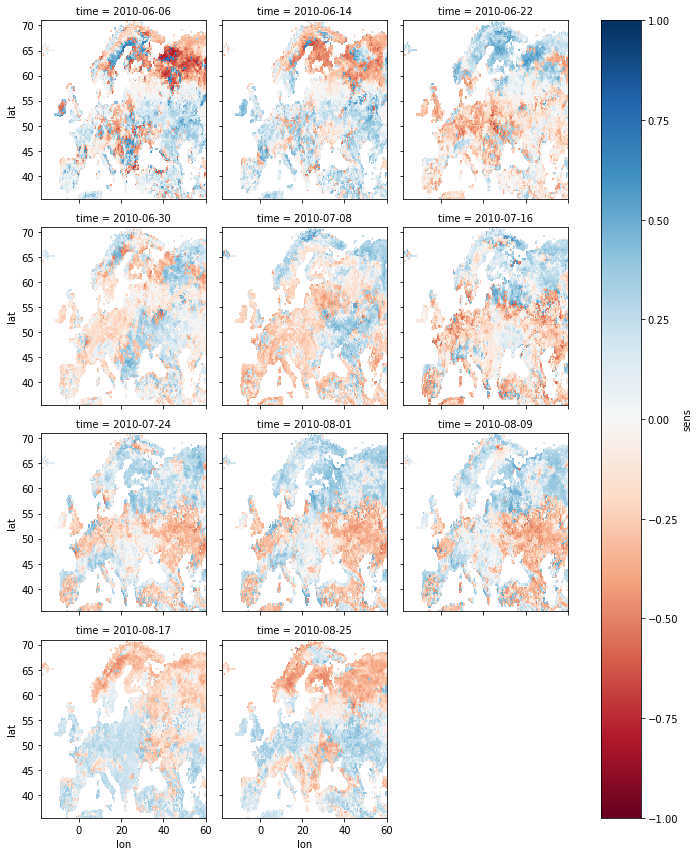

In [54]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=False)

### Sensitivity

Converting Cartesian to Polar Coordinates

* Modulus: $r = \sqrt{x^2 + y^2}$
* Angle: $\theta = \arctan{\frac{y}{x}}$

In [271]:
%%time

# Calculate the Modulus of the Derivatives
mod_sens['rhsic'] = np.sqrt(np.abs(derX['rhsic']) + np.abs(derY['rhsic']))

# Calculate the Direction of the Derivatives
ang_sens['rhsic'] = np.arctan2( 
    np.abs(derY['rhsic']), 
    np.abs(derX['rhsic']))

# Convert radians to degrees
ang_sens['rhsic'] = np.rad2deg(ang_sens['rhsic'])

CPU times: user 9.88 ms, sys: 2.84 ms, total: 12.7 ms
Wall time: 12.1 ms
